In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')  

# statsmodels.regression.rolling: Importing the RollingOLS class for rolling linear regression.
# pandas_datareader.data: Importing the web module from pandas_datareader for fetching financial data.
# matplotlib.pyplot: Importing the pyplot module for plotting.
# statsmodels.api: Importing the statsmodels library for statistical models and tests.
# pandas: Importing the pandas library for data manipulation and analysis.
# numpy: Importing the numpy library for numerical operations.
# datetime: Importing the datetime module for working with dates.
# yfinance: Importing the yfinance library for fetching financial data from Yahoo Finance.
# pandas_ta: Importing the pandas_ta library for technical analysis.
# warnings: Importing the warnings module to suppress warnings.

# downloading the data
nifty50 = pd.read_html('https://en.wikipedia.org/wiki/NIFTY_50')[2]
symbols_list = nifty50['Symbol'].unique().tolist()

# Add '.NS' to each ticker symbol in the list
symbols_list = [ticker + '.NS' for ticker in symbols_list]

# Display the modified list
print(symbols_list)


end_date = '2024-1-31'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

# Setting start and end dates:
# Defining the end_date as '2023-12-03'.
# Calculating the start_date as 8 years (365 days * 8) before the end_date.capitalize

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

['ADANIENT.NS', 'ADANIPORTS.NS', 'APOLLOHOSP.NS', 'ASIANPAINT.NS', 'AXISBANK.NS', 'BAJAJ-AUTO.NS', 'BAJFINANCE.NS', 'BAJAJFINSV.NS', 'BPCL.NS', 'BHARTIARTL.NS', 'BRITANNIA.NS', 'CIPLA.NS', 'COALINDIA.NS', 'DIVISLAB.NS', 'DRREDDY.NS', 'EICHERMOT.NS', 'GRASIM.NS', 'HCLTECH.NS', 'HDFCBANK.NS', 'HDFCLIFE.NS', 'HEROMOTOCO.NS', 'HINDALCO.NS', 'HINDUNILVR.NS', 'ICICIBANK.NS', 'INDUSINDBK.NS', 'INFY.NS', 'ITC.NS', 'JSWSTEEL.NS', 'KOTAKBANK.NS', 'LT.NS', 'LTIM.NS', 'M&M.NS', 'MARUTI.NS', 'NESTLEIND.NS', 'NTPC.NS', 'ONGC.NS', 'POWERGRID.NS', 'RELIANCE.NS', 'SBILIFE.NS', 'SBIN.NS', 'SUNPHARMA.NS', 'TATAMOTORS.NS', 'TATASTEEL.NS', 'TCS.NS', 'TATACONSUM.NS', 'TECHM.NS', 'TITAN.NS', 'ULTRACEMCO.NS', 'UPL.NS', 'WIPRO.NS']
[*********************100%%**********************]  50 of 50 completed


adj close        close          high          low  \
date       ticker                                                               
2016-02-02 ADANIENT.NS      38.056499    39.260132     40.731365    38.796967   
           ADANIPORTS.NS   203.878296   213.250000    223.949997   211.699997   
           APOLLOHOSP.NS  1394.307983  1434.300049   1525.000000  1424.599976   
           ASIANPAINT.NS   835.911438   882.500000    894.750000   878.000000   
           AXISBANK.NS     382.062744   390.899994    404.450012   388.600006   
...                               ...          ...           ...          ...   
2024-01-30 TECHM.NS       1317.849976  1317.849976   1340.949951  1315.000000   
           TITAN.NS       3735.750000  3735.750000   3886.949951  3715.000000   
           ULTRACEMCO.NS  9963.599609  9963.599609  10320.000000  9942.000000   
           UPL.NS          535.250000   535.250000    547.500000   534.400024   
           WIPRO.NS        472.500000   472.500000    482.899994   471.500000   

                                  open      volume  
date       ticker                                   
2016-02-02 ADANIENT.NS       40.431671   4281060.0  
           ADANIPORTS.NS    221.949997   2971041.0  
           APOLLOHOSP.NS   1506.900024    282208.0  
           ASIANPAINT.NS    889.900024    920875.0  
           AXISBANK.NS      399.000000  12131028.0  
...                                ...         ...  
2024-01-30 TECHM.NS        1323.949951   2293154.0  
           TITAN.NS        3882.000000    852445.0  
           ULTRACEMCO.NS  10289.750000    368827.0  
           UPL.NS           541.900024   1912294.0  
           WIPRO.NS         474.399994   5914007.0  

[97731 rows x 6 columns]

### Calculate features and technical indicators

* Garman -klass volatilit
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

In [2]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

# df: This is the DataFrame on which the grouping operation is applied.

# .groupby(level=1): This is a method provided by pandas for grouping data based on one or more levels of a multi-level index. In this case, it's specifying to group the DataFrame by the second level of its index.

# The index of df has two levels ('date' and 'ticker'). By specifying level=1, the grouping is done based on the 'ticker' level. This means that the DataFrame will be split into groups, each corresponding to a unique 'ticker' in the second level of the index.

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

# 1e6 is a shorthand notation in Python for expressing the number 1 followed by 6 zeros, which is equivalent to 1,000,000. It is often used to represent one million in a more concise form.

df

adj close        close          high          low  \
date       ticker                                                               
2016-02-02 ADANIENT.NS      38.056499    39.260132     40.731365    38.796967   
           ADANIPORTS.NS   203.878296   213.250000    223.949997   211.699997   
           APOLLOHOSP.NS  1394.307983  1434.300049   1525.000000  1424.599976   
           ASIANPAINT.NS   835.911438   882.500000    894.750000   878.000000   
           AXISBANK.NS     382.062744   390.899994    404.450012   388.600006   
...                               ...          ...           ...          ...   
2024-01-30 TECHM.NS       1317.849976  1317.849976   1340.949951  1315.000000   
           TITAN.NS       3735.750000  3735.750000   3886.949951  3715.000000   
           ULTRACEMCO.NS  9963.599609  9963.599609  10320.000000  9942.000000   
           UPL.NS          535.250000   535.250000    547.500000   534.400024   
           WIPRO.NS        472.500000   472.500000    482.899994   471.500000   

                                  open      volume  garman_klass_vol  \
date       ticker                                                      
2016-02-02 ADANIENT.NS       40.431671   4281060.0         -0.000232   
           ADANIPORTS.NS    221.949997   2971041.0         -0.001204   
           APOLLOHOSP.NS   1506.900024    282208.0         -0.000011   
           ASIANPAINT.NS    889.900024    920875.0         -0.001335   
           AXISBANK.NS      399.000000  12131028.0          0.000072   
...                                ...         ...               ...   
2024-01-30 TECHM.NS        1323.949951   2293154.0          0.000183   
           TITAN.NS        3882.000000    852445.0          0.000454   
           ULTRACEMCO.NS  10289.750000    368827.0          0.000295   
           UPL.NS           541.900024   1912294.0          0.000234   
           WIPRO.NS         474.399994   5914007.0          0.000279   

                                rsi    bb_low    bb_mid   bb_high       atr  \
date       ticker                                                             
2016-02-02 ADANIENT.NS          NaN       NaN       NaN       NaN       NaN   
           ADANIPORTS.NS        NaN       NaN       NaN       NaN       NaN   
           APOLLOHOSP.NS        NaN       NaN       NaN       NaN       NaN   
           ASIANPAINT.NS        NaN       NaN       NaN       NaN       NaN   
           AXISBANK.NS          NaN       NaN       NaN       NaN       NaN   
...                             ...       ...       ...       ...       ...   
2024-01-30 TECHM.NS       54.497785  7.091318  7.171500  7.251681  1.752537   
           TITAN.NS       54.893945  8.200865  8.228010  8.255155  2.542950   
           ULTRACEMCO.NS  53.623622  9.177835  9.210025  9.242216  2.477912   
           UPL.NS         37.605205  6.264742  6.331110  6.397477 -0.881272   
           WIPRO.NS       57.631865  6.091774  6.149844  6.207914  1.757520   

                              macd  dollar_volume  
date       ticker                                  
2016-02-02 ADANIENT.NS         NaN     162.922158  
           ADANIPORTS.NS       NaN     605.730776  
           APOLLOHOSP.NS       NaN     393.484867  
           ASIANPAINT.NS       NaN     769.769945  
           AXISBANK.NS         NaN    4634.813847  
...                            ...            ...  
2024-01-30 TECHM.NS       1.201057    3022.032943  
           TITAN.NS       1.215169    3184.521409  
           ULTRACEMCO.NS  0.522390    3674.844553  
           UPL.NS        -1.013769    1023.555363  
           WIPRO.NS       1.123383    2794.368307  

[97731 rows x 14 columns]

In [3]:
import pandas as pd

# Read HTML tables from the Wikipedia page
tables = pd.read_html('https://en.wikipedia.org/wiki/NIFTY_500#Other_Notable_Indices', header=0)

# Print the number of tables found
print(f"Number of tables found: {len(tables)}")

# Print the columns of each table to understand their structure
for i, table in enumerate(tables):
    print(f"Table {i} columns:\n{table.columns}\n{'='*50}")

# Check if the list has an element at the expected index
if len(tables) > 4:
    nifty50 = tables[4]
    # Ensure the 'Symbol' column is present in the DataFrame
    if 'Symbol' in nifty50.columns:
        symbols_list = nifty50['Symbol'].unique().tolist()
        # Add '.NS' to each ticker symbol in the list
        symbols_list = [ticker + '.NS' for ticker in symbols_list]
        print("Symbols List:", symbols_list)
    else:
        print("Error: 'Symbol' column not found in the DataFrame.")
else:
    print("Error: List index out of range.")


Number of tables found: 3
Table 0 columns:
Index(['Unnamed: 0', 'Unnamed: 1'], dtype='object')
Table 1 columns:
Index(['Category', 'All-time highs[5]', 'All-time highs[5].1'], dtype='object')
Table 2 columns:
Index(['Sl.No', 'Company Name', 'Industry', 'Symbol', 'Series', 'ISIN Code'], dtype='object')
Error: List index out of range.


# Taking First 30 Companies beacuse also listed in Sensex

## Getting monthly index and average dollar volume and making it multiindex

In [4]:
last_cols =[c for c in df.columns.unique(0)if c not in['dollar_volume','volume','open','high','low','close']]
# exclude given column and include all the remaining one and store it in last_cols
last_cols
data=pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
# Resamples the 'dollar_volume' column by month, calculates the mean for each month, and then stacks the DataFrame.
#The result is a DataFrame with a MultiIndex containing levels 'date' and 'ticker', with the 'dollar_volume' as a single column.
# The capital M stands for month dollar volume mean is taken             
df.unstack()[last_cols].resample('M').last().stack('ticker')],axis=1).dropna()
# Unstacks the entire DataFrame and selects only the columns specified in last_cols.
# Resamples the resulting DataFrame by month and selects the last value for each month.
data

dollar_volume    adj close  garman_klass_vol  \
date       ticker                                                        
2016-03-31 ADANIENT.NS       254.719101    39.402481          0.000513   
           ADANIPORTS.NS     701.712683   237.887405         -0.000094   
           APOLLOHOSP.NS     381.330776  1297.792603          0.000802   
           ASIANPAINT.NS     983.519913   822.555908         -0.001550   
           AXISBANK.NS      3767.325327   434.108917          0.000112   
...                                 ...          ...               ...   
2024-01-31 TECHM.NS         3749.755292  1317.849976          0.000183   
           TITAN.NS         3121.944189  3735.750000          0.000454   
           ULTRACEMCO.NS    2997.690709  9963.599609          0.000295   
           UPL.NS           1487.390171   535.250000          0.000234   
           WIPRO.NS         5409.069974   472.500000          0.000279   

                                rsi    bb_low    bb_mid   bb_high       atr  \
date       ticker                                                             
2016-03-31 ADANIENT.NS    64.719155  3.490645  3.592896  3.695146 -0.727470   
           ADANIPORTS.NS  67.503692  5.322734  5.408070  5.493406 -0.880472   
           APOLLOHOSP.NS  37.242955  7.152670  7.213966  7.275262 -0.668868   
           ASIANPAINT.NS  49.383308  6.684154  6.717984  6.751814 -1.161378   
           AXISBANK.NS    62.696329  5.962331  6.028032  6.093734 -0.952292   
...                             ...       ...       ...       ...       ...   
2024-01-31 TECHM.NS       54.497785  7.091318  7.171500  7.251681  1.752537   
           TITAN.NS       54.893945  8.200865  8.228010  8.255155  2.542950   
           ULTRACEMCO.NS  53.623622  9.177835  9.210025  9.242216  2.477912   
           UPL.NS         37.605205  6.264742  6.331110  6.397477 -0.881272   
           WIPRO.NS       57.631865  6.091774  6.149844  6.207914  1.757520   

                              macd  
date       ticker                   
2016-03-31 ADANIENT.NS   -0.138745  
           ADANIPORTS.NS  0.425985  
           APOLLOHOSP.NS -0.595237  
           ASIANPAINT.NS -0.285622  
           AXISBANK.NS    0.602729  
...                            ...  
2024-01-31 TECHM.NS       1.201057  
           TITAN.NS       1.215169  
           ULTRACEMCO.NS  0.522390  
           UPL.NS        -1.013769  
           WIPRO.NS       1.123383  

[4704 rows x 9 columns]

In [5]:
data['dollar_volume'].unstack('ticker').rolling(5*12).mean()
#This applies a rolling window operation with a window size of 5*12 (60) periods.

ticker      ADANIENT.NS  ADANIPORTS.NS  APOLLOHOSP.NS  ASIANPAINT.NS  \
date                                                                   
2016-03-31          NaN            NaN            NaN            NaN   
2016-04-30          NaN            NaN            NaN            NaN   
2016-05-31          NaN            NaN            NaN            NaN   
2016-06-30          NaN            NaN            NaN            NaN   
2016-07-31          NaN            NaN            NaN            NaN   
...                 ...            ...            ...            ...   
2023-09-30  5289.349016    4414.936794    2296.360564    3430.771450   
2023-10-31  5327.569629    4434.702729    2319.249331    3447.116466   
2023-11-30  5392.606283    4469.741522    2345.554058    3458.263414   
2023-12-31  5623.716078    4627.327943    2378.959566    3480.072204   
2024-01-31  5797.931999    4761.405636    2399.637824    3504.865931   

ticker      AXISBANK.NS  BAJAJ-AUTO.NS  BAJAJFINSV.NS  BAJFINANCE.NS  \
date                                                                   
2016-03-31          NaN            NaN            NaN            NaN   
2016-04-30          NaN            NaN            NaN            NaN   
2016-05-31          NaN            NaN            NaN            NaN   
2016-06-30          NaN            NaN            NaN            NaN   
2016-07-31          NaN            NaN            NaN            NaN   
...                 ...            ...            ...            ...   
2023-09-30  9141.344819    1646.657234    3861.781911   10254.986992   
2023-10-31  9169.345878    1678.113590    3875.297051   10211.609026   
2023-11-30  9182.269954    1706.573624    3892.991986   10295.342627   
2023-12-31  9268.108806    1741.324678    3906.341301   10358.063933   
2024-01-31  9325.285865    1808.111493    3924.397590   10466.747220   

ticker      BHARTIARTL.NS      BPCL.NS  ...  SUNPHARMA.NS  TATACONSUM.NS  \
date                                    ...                                
2016-03-31            NaN          NaN  ...           NaN            NaN   
2016-04-30            NaN          NaN  ...           NaN            NaN   
2016-05-31            NaN          NaN  ...           NaN            NaN   
2016-06-30            NaN          NaN  ...           NaN            NaN   
2016-07-31            NaN          NaN  ...           NaN            NaN   
...                   ...          ...  ...           ...            ...   
2023-09-30    6426.648799  2149.083418  ...   3471.658483    1420.868504   
2023-10-31    6460.267484  2128.857423  ...   3459.743844    1434.236426   
2023-11-30    6489.286549  2149.076662  ...   3429.639123    1451.026713   
2023-12-31    6548.892994  2215.049402  ...   3333.142373    1470.698132   
2024-01-31    6622.661702  2272.416139  ...   3278.895202    1498.974002   

ticker      TATAMOTORS.NS  TATASTEEL.NS       TCS.NS     TECHM.NS  \
date                                                                
2016-03-31            NaN           NaN          NaN          NaN   
2016-04-30            NaN           NaN          NaN          NaN   
2016-05-31            NaN           NaN          NaN          NaN   
2016-06-30            NaN           NaN          NaN          NaN   
2016-07-31            NaN           NaN          NaN          NaN   
...                   ...           ...          ...          ...   
2023-09-30    9096.440346   7304.117413  7287.941977  2845.192866   
2023-10-31    9148.780459   7303.591509  7308.918803  2853.232774   
2023-11-30    9218.938131   7293.391000  7337.597574  2853.486566   
2023-12-31    9308.651271   7326.598705  7406.632487  2879.056771   
2024-01-31    9410.320953   7365.405705  7464.390352  2919.995701   

ticker         TITAN.NS  ULTRACEMCO.NS       UPL.NS     WIPRO.NS  
date                                                              
2016-03-31          NaN            NaN          NaN          NaN  
2016-04-30          NaN            NaN

# make changes here to adjust ticker name in dollar volume 

In [6]:
data['dollar_vol_rank']= (data.groupby('date')['dollar_volume'].rank(ascending=False))
#selecting rows where the 'dollar_vol_rank' is less than 30.
data = data[data['dollar_vol_rank']<500].drop(['dollar_volume','dollar_vol_rank'],axis=1)

In [7]:
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                              
2016-03-31 ADANIENT.NS      39.402481          0.000513  64.719155  3.490645   
           ADANIPORTS.NS   237.887405         -0.000094  67.503692  5.322734   
           APOLLOHOSP.NS  1297.792603          0.000802  37.242955  7.152670   
           ASIANPAINT.NS   822.555908         -0.001550  49.383308  6.684154   
           AXISBANK.NS     434.108917          0.000112  62.696329  5.962331   
...                               ...               ...        ...       ...   
2024-01-31 TECHM.NS       1317.849976          0.000183  54.497785  7.091318   
           TITAN.NS       3735.750000          0.000454  54.893945  8.200865   
           ULTRACEMCO.NS  9963.599609          0.000295  53.623622  9.177835   
           UPL.NS          535.250000          0.000234  37.605205  6.264742   
           WIPRO.NS        472.500000          0.000279  57.631865  6.091774   

                            bb_mid   bb_high       atr      macd  
date       ticker                                                 
2016-03-31 ADANIENT.NS    3.592896  3.695146 -0.727470 -0.138745  
           ADANIPORTS.NS  5.408070  5.493406 -0.880472  0.425985  
           APOLLOHOSP.NS  7.213966  7.275262 -0.668868 -0.595237  
           ASIANPAINT.NS  6.717984  6.751814 -1.161378 -0.285622  
           AXISBANK.NS    6.028032  6.093734 -0.952292  0.602729  
...                            ...       ...       ...       ...  
2024-01-31 TECHM.NS       7.171500  7.251681  1.752537  1.201057  
           TITAN.NS       8.228010  8.255155  2.542950  1.215169  
           ULTRACEMCO.NS  9.210025  9.242216  2.477912  0.522390  
           UPL.NS         6.331110  6.397477 -0.881272 -1.013769  
           WIPRO.NS       6.149844  6.207914  1.757520  1.123383  

[4704 rows x 8 columns]

# Calculate Monthly returns for different time horizion features
* TO capture time series dynamics that reflects ,for example,momentum patterns, we compute historical returns using the method .pct_change(lag) that is, returns over various monthly periods as identified by lags

In [8]:
def calculate_returns(df):
    
   
    outlier_cutoff =0.005
    # what is a outlier
    # refer this video 'https://youtu.be/rZJbj2I-_Ek?feature=shared'
    # an outlier helps us to konw irrelevance in data like 9,10,10,11,12,36 so outlier is used and 36 is removed
    lags=[1,2,3,6,9,12]
    for lag in lags:
        df[f'return_{lag}m']=(df['adj close'] #: Creates a new column in the DataFrame for each lag, representing returns over that lag period.
                            .pct_change(lag)  #Calculates the percentage change over the specified lag period.
                            .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),upper=x.quantile(1-outlier_cutoff)))
                            .add(1)
                            .pow(1/lag)
                            .sub(1))
    return df

data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna() #Applies the calculate_returns function to each group of the DataFrame, grouping by the second level of the index ('ticker').
# .dropna(): Drops any rows with missing values in the resulting DataFrame.
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                              
2017-03-31 ADANIENT.NS      57.955814          0.001078  67.437649  3.917253   
           ADANIPORTS.NS   326.146790         -0.000675  68.082250  5.645352   
           APOLLOHOSP.NS  1137.533203          0.000036  39.940303  7.013172   
           ASIANPAINT.NS  1024.793335         -0.000628  61.406707  6.874274   
           AXISBANK.NS     484.190033          0.000067  47.576609  6.165180   
...                               ...               ...        ...       ...   
2024-01-31 TECHM.NS       1317.849976          0.000183  54.497785  7.091318   
           TITAN.NS       3735.750000          0.000454  54.893945  8.200865   
           ULTRACEMCO.NS  9963.599609          0.000295  53.623622  9.177835   
           UPL.NS          535.250000          0.000234  37.605205  6.264742   
           WIPRO.NS        472.500000          0.000279  57.631865  6.091774   

                            bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                             
2017-03-31 ADANIENT.NS    4.005770  4.094287 -0.722817 -0.123147   0.102030   
           ADANIPORTS.NS  5.722332  5.799313 -0.934239  0.298638   0.125435   
           APOLLOHOSP.NS  7.068295  7.123417 -1.036850 -0.618353  -0.104867   
           ASIANPAINT.NS  6.915546  6.956817 -1.190762  0.191916   0.048135   
           AXISBANK.NS    6.210532  6.255885 -0.962747 -0.241542  -0.031284   
...                            ...       ...       ...       ...        ...   
2024-01-31 TECHM.NS       7.171500  7.251681  1.752537  1.201057   0.035516   
           TITAN.NS       8.228010  8.255155  2.542950  1.215169   0.016406   
           ULTRACEMCO.NS  9.210025  9.242216  2.477912  0.522390  -0.051361   
           UPL.NS         6.331110  6.397477 -0.881272 -1.013769  -0.088548   
           WIPRO.NS       6.149844  6.207914  1.757520  1.123383   0.004684   

                          return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                      
2017-03-31 ADANIENT.NS     0.116044   0.123470   0.087287   0.025222   
           ADANIPORTS.NS   0.075947   0.081520   0.047714   0.056632   
           APOLLOHOSP.NS  -0.026739  -0.004185  -0.019764  -0.013395   
           ASIANPAINT.NS   0.051619   0.064061  -0.012524   0.007820   
           AXISBANK.NS     0.026264   0.029390  -0.016205  -0.008201   
...                             ...        ...        ...        ...   
2024-01-31 TECHM.NS        0.038925   0.055387   0.030012   0.035645   
           TITAN.NS        0.034520   0.054091   0.036999   0.039621   
           ULTRACEMCO.NS   0.051959   0.057619   0.030540   0.031730   
           UPL.NS         -0.031514  -0.003248  -0.022779  -0.033647   
           WIPRO.NS        0.070686   0.074394   0.026368   0.023258   

                          return_12m  
date       ticker                     
2017-03-31 ADANIENT.NS      0.032677  
           ADANIPORTS.NS    0.026645  
           APOLLOHOSP.NS   -0.010923  
           ASIANPAINT.NS    0.018488  
           AXISBANK.NS      0.009140  
...                              ...  
2024-01-31 TECHM.NS         0.027347  
           TITAN.NS         0.038669  
           ULTRACEMCO.NS    0.029205  
           UPL.NS          -0.027175  
           WIPRO.NS         0.014401  

[4104 rows x 14 columns]

## Download Fama-French Factors and Calculate Rolling Factor Betas.
* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

### what is fama FRench model?

* but Gene Fama and Kenneth French noticed that small-cap stocks (companies with smaller market capitalizations) tended to outperform large-cap stocks and that companies with a higher book-to-market ratio (value stocks) tended to outperform companies with a lower book-to-market ratio (growth stocks).

* MKt-rf= it tells about market risk
* SMB long on portfolio with small cap stocks and short on portfolio on the large cap stocks
* HML long on portfolio with high book to market ratio and short on portfolio with low book to market ratio (low book to market ratio= companies that will grow eg paytm,ideaforage) high book to market are the value stocks
* Robust minus weak (RMW), which compares the returns of firms with high, or robust, operating profitability
* and those with weak, or low, operating profitability; and conservative minus aggressive (CMA)
* we are comparing the number to usa stock market because no data has been available for indian stock market but the numbers are taken on yearly basis so error is less and numbers remain constant

In [9]:
 factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF',axis=1)
factor_data.index = factor_data.index.to_timestamp()  
factor_data= factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                          
2017-03-31 ADANIENT.NS    0.0017  0.0074 -0.0335  0.0061 -0.0094   0.102030
           ADANIPORTS.NS  0.0017  0.0074 -0.0335  0.0061 -0.0094   0.125435
           APOLLOHOSP.NS  0.0017  0.0074 -0.0335  0.0061 -0.0094  -0.104867
           ASIANPAINT.NS  0.0017  0.0074 -0.0335  0.0061 -0.0094   0.048135
           AXISBANK.NS    0.0017  0.0074 -0.0335  0.0061 -0.0094  -0.031284
...                          ...     ...     ...     ...     ...        ...
2023-12-31 TECHM.NS       0.0485  0.0732  0.0494 -0.0307  0.0132   0.042344
           TITAN.NS       0.0485  0.0732  0.0494 -0.0307  0.0132   0.052956
           ULTRACEMCO.NS  0.0485  0.0732  0.0494 -0.0307  0.0132   0.166532
           UPL.NS         0.0485  0.0732  0.0494 -0.0307  0.0132   0.029090
           WIPRO.NS       0.0485  0.0732  0.0494 -0.0307  0.0132   0.141024

[4054 rows x 6 columns]

In [10]:
observation = factor_data.groupby(level=1).size()
valid_stocks = observation[observation>=10]
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]
factor_data
# Checks if each 'ticker' is in the index of valid stocks obtained in the previous step.
# factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]: Filters the DataFrame to include only rows corresponding to valid stocks.

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                          
2017-03-31 ADANIENT.NS    0.0017  0.0074 -0.0335  0.0061 -0.0094   0.102030
           ADANIPORTS.NS  0.0017  0.0074 -0.0335  0.0061 -0.0094   0.125435
           APOLLOHOSP.NS  0.0017  0.0074 -0.0335  0.0061 -0.0094  -0.104867
           ASIANPAINT.NS  0.0017  0.0074 -0.0335  0.0061 -0.0094   0.048135
           AXISBANK.NS    0.0017  0.0074 -0.0335  0.0061 -0.0094  -0.031284
...                          ...     ...     ...     ...     ...        ...
2023-12-31 TECHM.NS       0.0485  0.0732  0.0494 -0.0307  0.0132   0.042344
           TITAN.NS       0.0485  0.0732  0.0494 -0.0307  0.0132   0.052956
           ULTRACEMCO.NS  0.0485  0.0732  0.0494 -0.0307  0.0132   0.166532
           UPL.NS         0.0485  0.0732  0.0494 -0.0307  0.0132   0.029090
           WIPRO.NS       0.0485  0.0732  0.0494 -0.0307  0.0132   0.141024

[4054 rows x 6 columns]

In [11]:
betas =(factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))
betas
#the code calculates rolling betas for each stock by applying the RollingOLS model to the 'return_1m' as the dependent variable and the other factors from the factor_data DataFrame as independent variables. The rolling window size is 
# determined by the minimum of 24 and the number of observations available for each stock. The resulting betas DataFrame contains the time-varying beta coefficients for each stock with respect to the specified factors.
# rolling returns gives the average of any stocks that give return for eg market is up 3% than it wont affect rolling return

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                         
2017-03-31 ADANIENT.NS         NaN       NaN       NaN       NaN       NaN
           ADANIPORTS.NS       NaN       NaN       NaN       NaN       NaN
           APOLLOHOSP.NS       NaN       NaN       NaN       NaN       NaN
           ASIANPAINT.NS       NaN       NaN       NaN       NaN       NaN
           AXISBANK.NS         NaN       NaN       NaN       NaN       NaN
...                            ...       ...       ...       ...       ...
2023-12-31 TECHM.NS       0.854021 -0.203819 -0.140364 -0.530616 -0.328796
           TITAN.NS       0.591866 -0.457480  0.010236 -0.744098 -0.287911
           ULTRACEMCO.NS  0.719574  0.252664  0.002453  0.210155 -0.241784
           UPL.NS         1.133841 -0.686002 -0.133436 -0.149137  0.807209
           WIPRO.NS       0.737416  0.281224 -0.426474 -0.604132  0.356137

[4054 rows x 5 columns]

In [12]:
factors=['Mkt-RF','SMB','HML','RMW','CMA']

data =data.join(betas.groupby('ticker').shift())
data.loc[:,factors] = data.groupby('ticker',group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))
data = data.dropna()
data = data.drop('adj close', axis=1)
data
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4104 entries, (Timestamp('2017-03-31 00:00:00'), 'ADANIENT.NS') to (Timestamp('2024-01-31 00:00:00'), 'WIPRO.NS')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  4104 non-null   float64
 1   rsi               4104 non-null   float64
 2   bb_low            4104 non-null   float64
 3   bb_mid            4104 non-null   float64
 4   bb_high           4104 non-null   float64
 5   atr               4104 non-null   float64
 6   macd              4104 non-null   float64
 7   return_1m         4104 non-null   float64
 8   return_2m         4104 non-null   float64
 9   return_3m         4104 non-null   float64
 10  return_6m         4104 non-null   float64
 11  return_9m         4104 non-null   float64
 12  return_12m        4104 non-null   float64
 13  Mkt-RF            4104 non-null   float64
 14  SMB               4104 non-null   float64
 15 

# At this point we have to decide on what ML model and approach to use for predictions etc.
6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
* K-Means Clustering

* You may want to initialize predefined centroids for each cluster based on your research.

* Then we will pre-define our centroids for each cluster.

In [13]:
from sklearn.cluster import KMeans

#data = data.drop('cluster',axis=1) # added later after clustering with random

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=10,
                           random_state=0,
                           init='random').fit(df).labels_ # changed 'random' to initial centriods
    return df
data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)
data



garman_klass_vol        rsi    bb_low    bb_mid  \
date       ticker                                                           
2017-03-31 ADANIENT.NS            0.001078  67.437649  3.917253  4.005770   
           ADANIPORTS.NS         -0.000675  68.082250  5.645352  5.722332   
           APOLLOHOSP.NS          0.000036  39.940303  7.013172  7.068295   
           ASIANPAINT.NS         -0.000628  61.406707  6.874274  6.915546   
           AXISBANK.NS            0.000067  47.576609  6.165180  6.210532   
...                                    ...        ...       ...       ...   
2024-01-31 TECHM.NS               0.000183  54.497785  7.091318  7.171500   
           TITAN.NS               0.000454  54.893945  8.200865  8.228010   
           ULTRACEMCO.NS          0.000295  53.623622  9.177835  9.210025   
           UPL.NS                 0.000234  37.605205  6.264742  6.331110   
           WIPRO.NS               0.000279  57.631865  6.091774  6.149844   

                           bb_high       atr      macd  return_1m  return_2m  \
date       ticker                                                              
2017-03-31 ADANIENT.NS    4.094287 -0.722817 -0.123147   0.102030   0.116044   
           ADANIPORTS.NS  5.799313 -0.934239  0.298638   0.125435   0.075947   
           APOLLOHOSP.NS  7.123417 -1.036850 -0.618353  -0.104867  -0.026739   
           ASIANPAINT.NS  6.956817 -1.190762  0.191916   0.048135   0.051619   
           AXISBANK.NS    6.255885 -0.962747 -0.241542  -0.031284   0.026264   
...                            ...       ...       ...        ...        ...   
2024-01-31 TECHM.NS       7.251681  1.752537  1.201057   0.035516   0.038925   
           TITAN.NS       8.255155  2.542950  1.215169   0.016406   0.034520   
           ULTRACEMCO.NS  9.242216  2.477912  0.522390  -0.051361   0.051959   
           UPL.NS         6.397477 -0.881272 -1.013769  -0.088548  -0.031514   
           WIPRO.NS       6.207914  1.757520  1.123383   0.004684   0.070686   

                          return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                       
2017-03-31 ADANIENT.NS     0.123470   0.087287   0.025222    0.032677   
           ADANIPORTS.NS   0.081520   0.047714   0.056632    0.026645   
           APOLLOHOSP.NS  -0.004185  -0.019764  -0.013395   -0.010923   
           ASIANPAINT.NS   0.064061  -0.012524   0.007820    0.018488   
           AXISBANK.NS     0.029390  -0.016205  -0.008201    0.009140   
...                             ...        ...        ...         ...   
2024-01-31 TECHM.NS        0.055387   0.030012   0.035645    0.027347   
           TITAN.NS        0.054091   0.036999   0.039621    0.038669   
           ULTRACEMCO.NS   0.057619   0.030540   0.031730    0.029205   
           UPL.NS         -0.003248  -0.022779  -0.033647   -0.027175   
           WIPRO.NS        0.074394   0.026368   0.023258    0.014401   

                            Mkt-RF       SMB       HML       RMW       CMA  \
date       ticker                                                            
2017-03-31 ADANIENT.NS    0.398289 -0.546472  0.397581  1.890638 -0.500539   
           ADANIPORTS.NS  0.230175  0.116486  0.497220  0.328945 -0.651044   
           APOLLOHOSP.NS  0.374700 -0.416517  0.233335 -0.188432 -1.379052   
           ASIANPAINT.NS  0.118651  0.161033  0.189737  0.408256 -0.256290   
           AXISBANK.NS    0.849098  0.214726  0.408220 -0.414940  0.043711   
...                            ...       ...       ...       ...       ...   
2024-01-31 TECHM.NS       0.688300 -0.488224  0.325515 -0.474993 -0.702060   
           TITAN.NS       0.358524  0.203554  0.376473  0.758710 -0.028387   
           ULTRACEMCO.NS  0.351529 -0.141420  0.691142  0.243236 -1.452401   
           UPL.NS         0.596278  0.212544  0.269222  0.633518  0.573136   
           WIPRO.NS       0.486848 -0.317518  0.274310 -0.066630 -0.630498   

                  

In [14]:
# def plot_clusters(data):

#     cluster_0 = data[data['cluster']==0]
#     cluster_1 = data[data['cluster']==1]
#     cluster_2 = data[data['cluster']==2]
#     cluster_3 = data[data['cluster']==3]
#     cluster_4 = data[data['cluster']==3]
#     cluster_3 = data[data['cluster']==3]
#     cluster_3 = data[data['cluster']==3]
#     cluster_3 = data[data['cluster']==3]
#     cluster_3 = data[data['cluster']==3]
#     cluster_3 = data[data['cluster']==3]
#     cluster_3 = data[data['cluster']==3]
#     cluster_3 = data[data['cluster']==3]
# # the impoertant thing we are chosing which column iloc[:,5] is atr and 1 is rsi
#     plt.scatter(cluster_0.iloc[:,5] , cluster_0.iloc[:,1] , color = 'red', label='cluster 0')
#     plt.scatter(cluster_1.iloc[:,5] , cluster_1.iloc[:,1] , color = 'green', label='cluster 1')
#     plt.scatter(cluster_2.iloc[:,5] , cluster_2.iloc[:,1] , color = 'blue', label='cluster 2')
#     plt.scatter(cluster_3.iloc[:,5] , cluster_3.iloc[:,1] , color = 'black', label='cluster 3')
# # labeling
#     x_label = data.columns[5]
#     y_label = data.columns[1]
#     plt.title(f'Clusters based on {x_label} and {y_label}')
#     plt.xlabel(x_label)
#     plt.ylabel(y_label)
#     plt.legend()
#     plt.show()
#     return
import matplotlib.pyplot as plt

def plot_clusters(data, num_clusters=10):
    # Iterate over clusters
    for cluster_num in range(num_clusters):
        cluster_data = data[data['cluster'] ==cluster_num]
        # Scatter plot for each cluster
        plt.scatter(cluster_data.iloc[:, 5], cluster_data.iloc[:, 1], label=f'cluster {cluster_num}')

    # Labeling
    x_label = data.columns[5]
    y_label = data.columns[1]
   
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()

# Example usage with 4 clusters
# Replace data and 'cluster' with your actual DataFrame and cluster column name
# plot_clusters(your_data_frame, num_clusters=4)


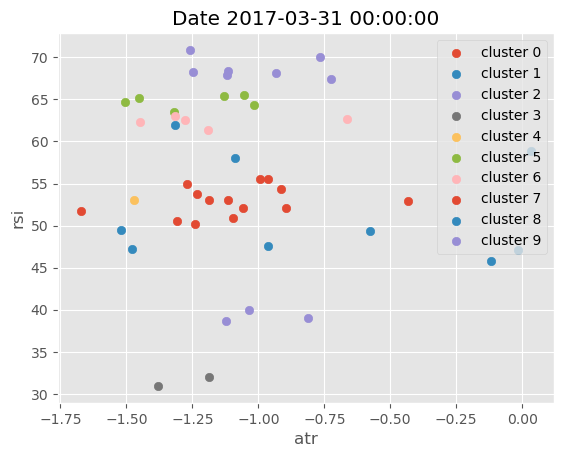

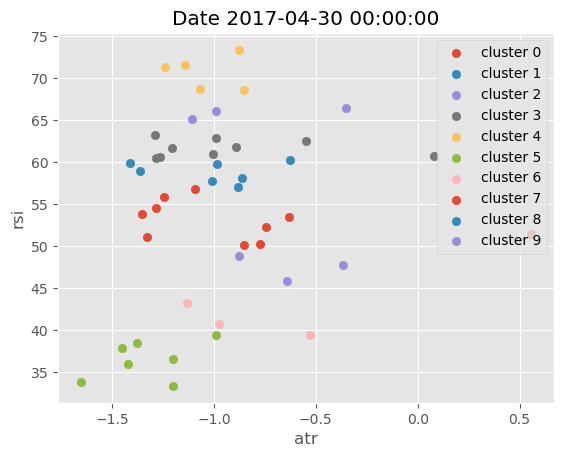

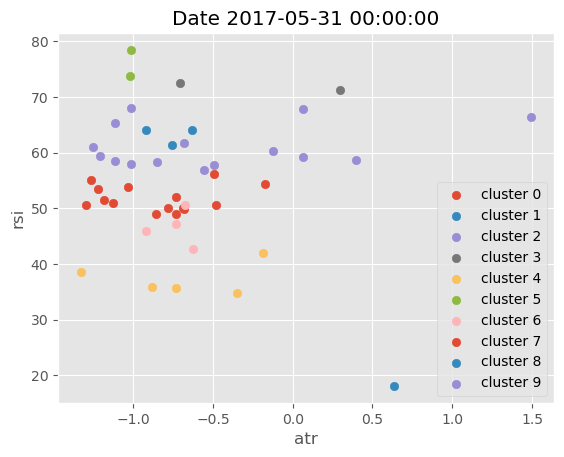

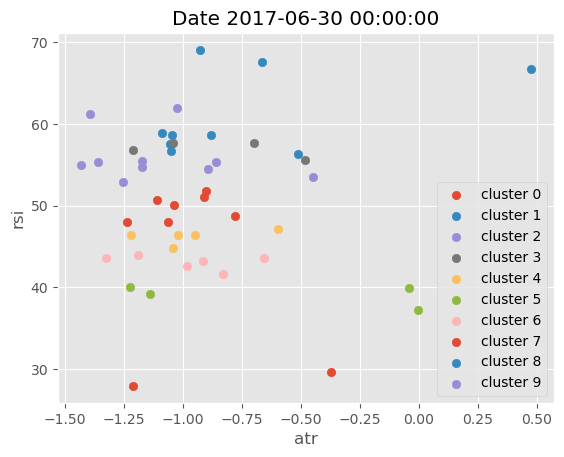

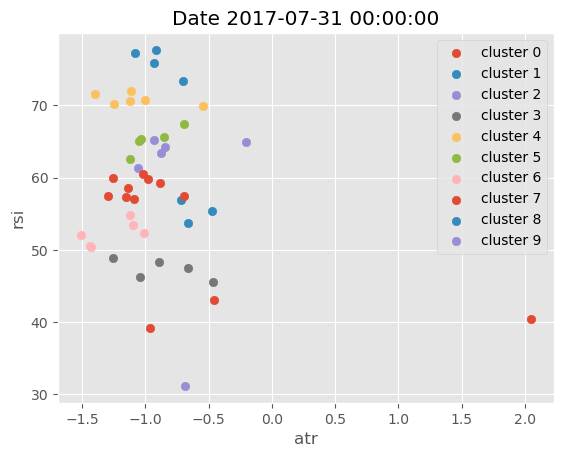

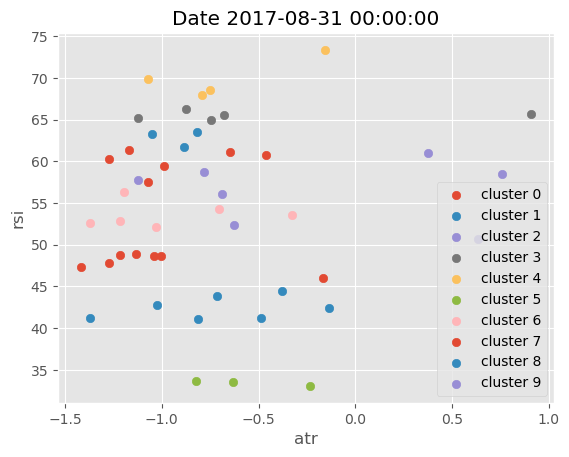

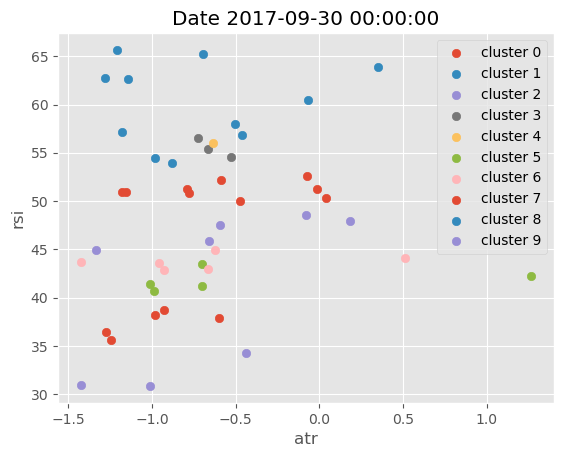

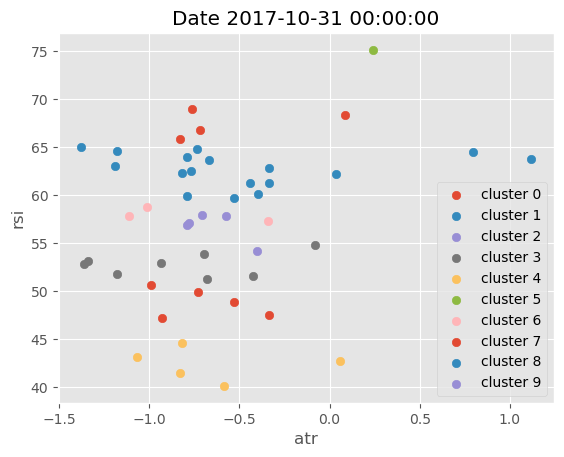

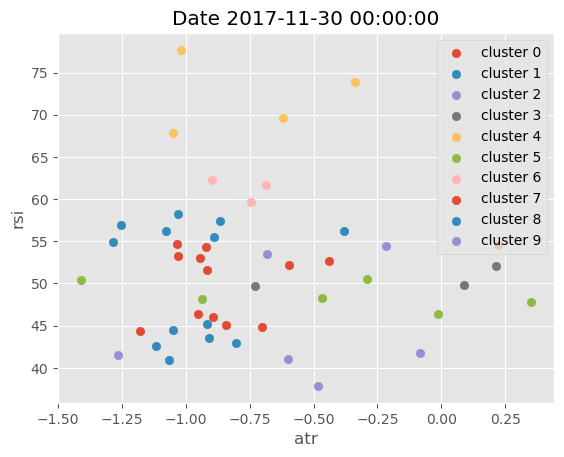

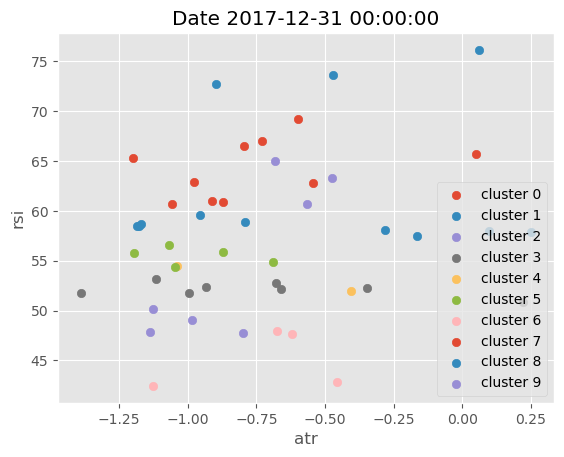

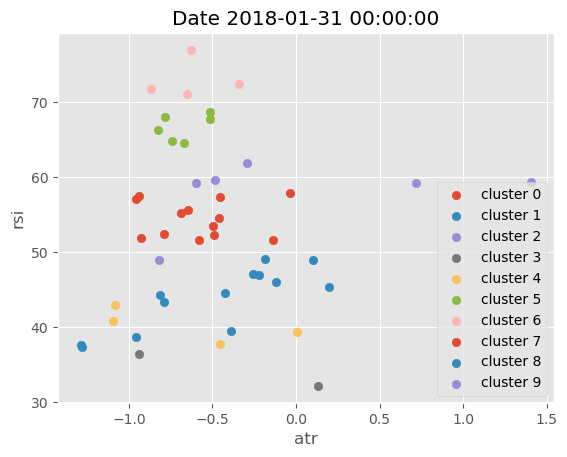

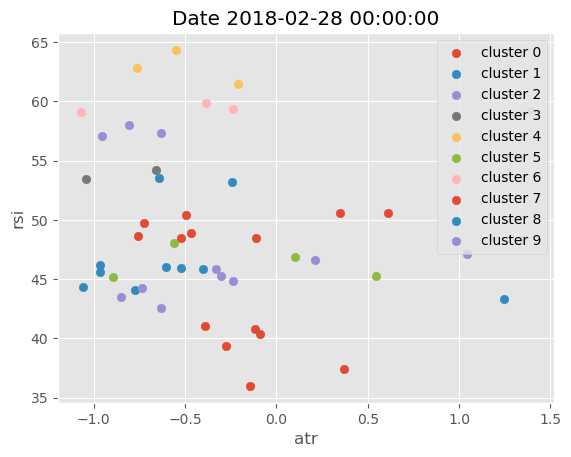

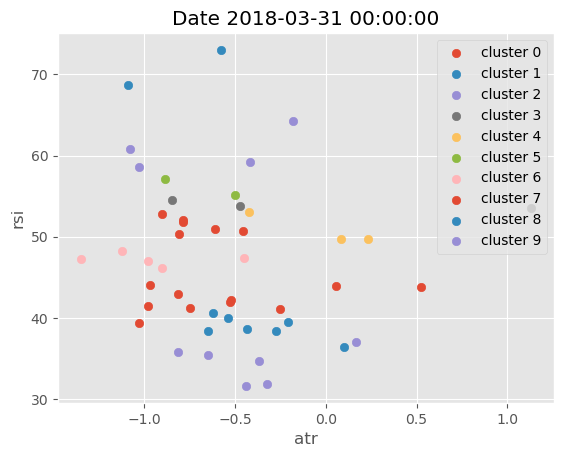

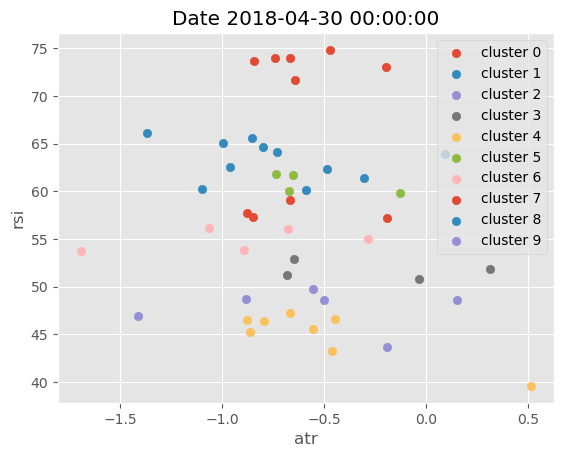

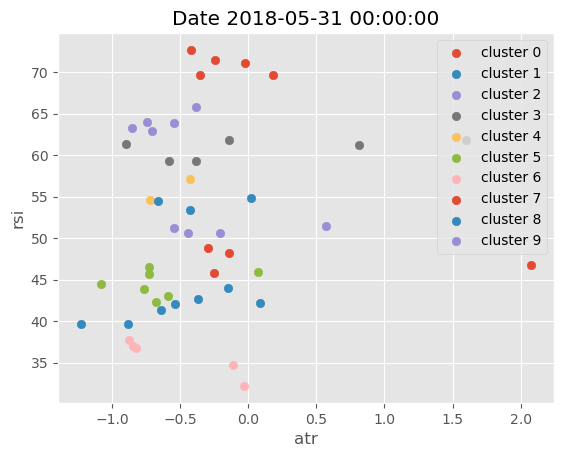

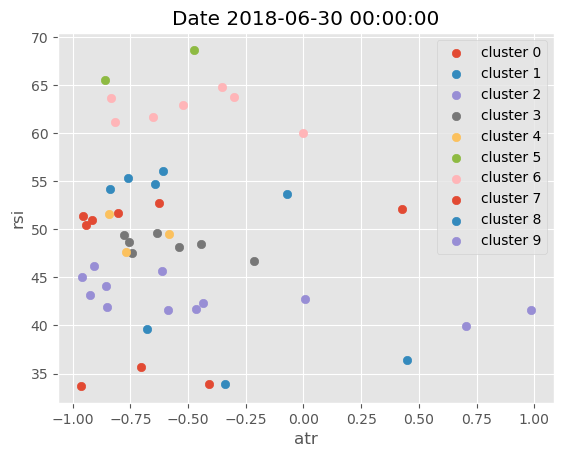

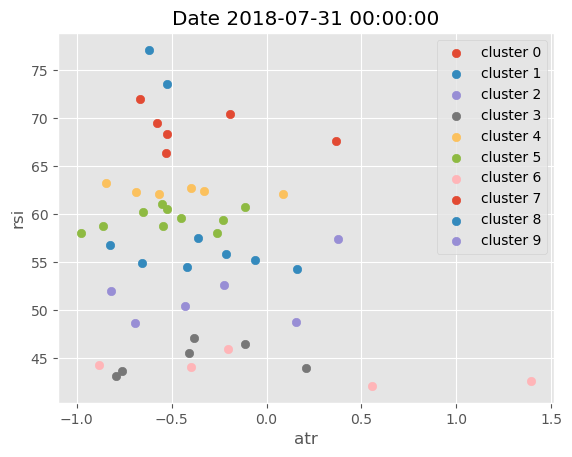

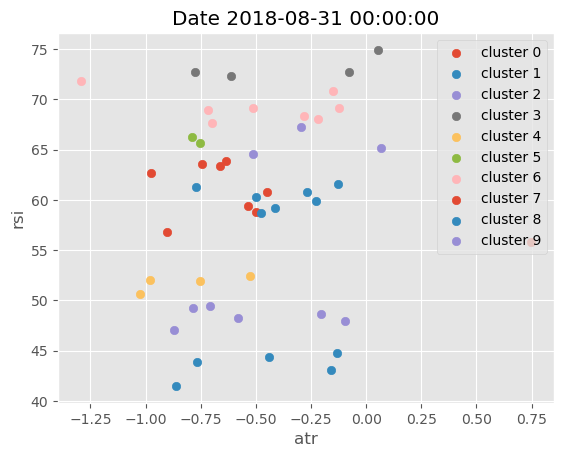

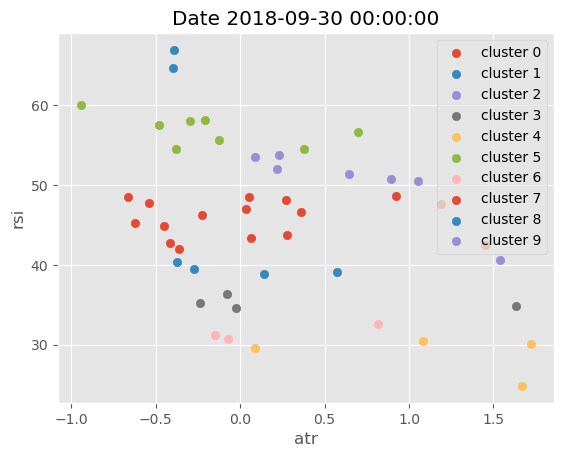

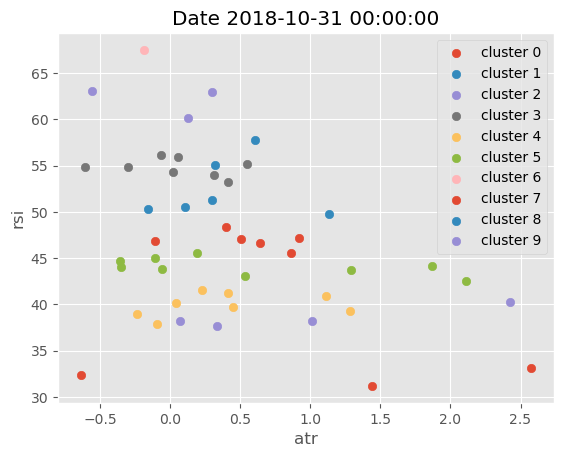

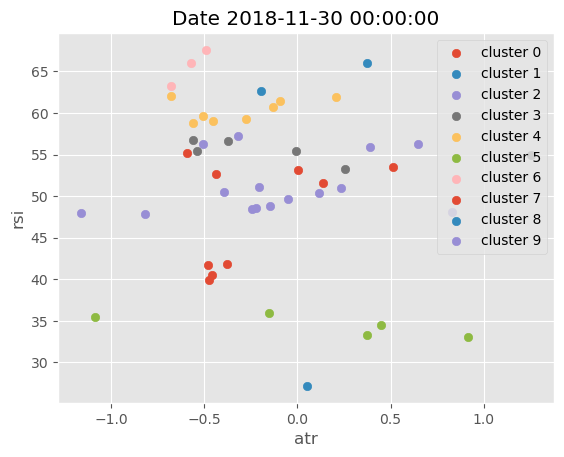

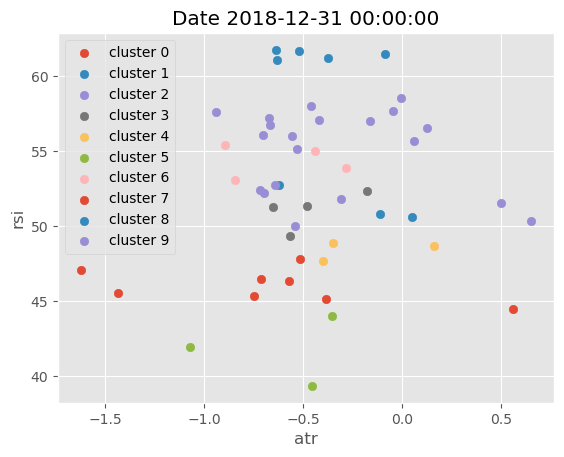

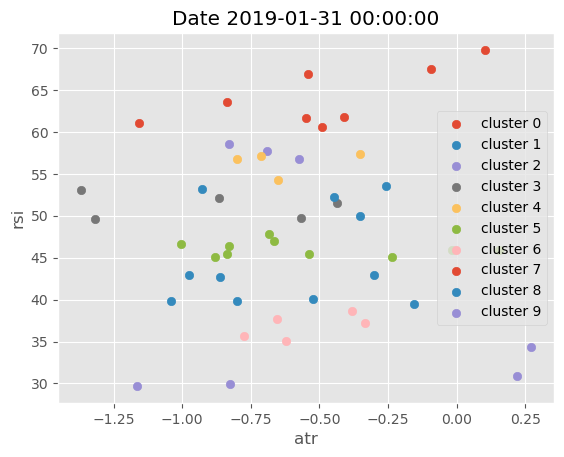

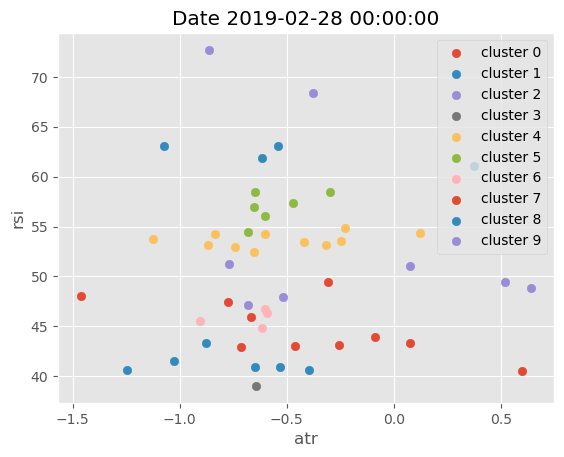

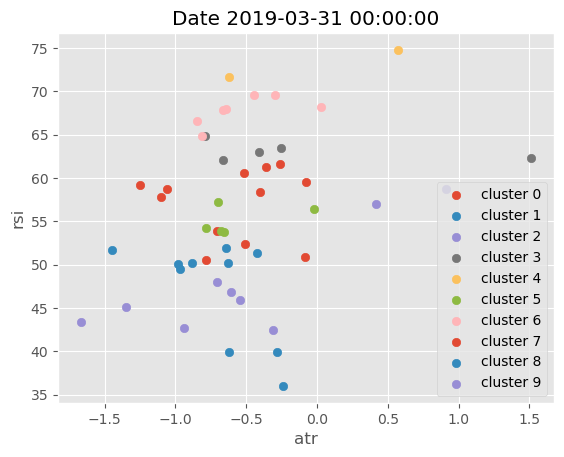

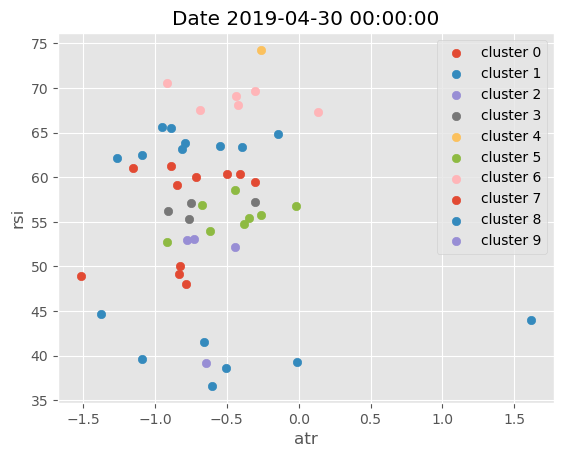

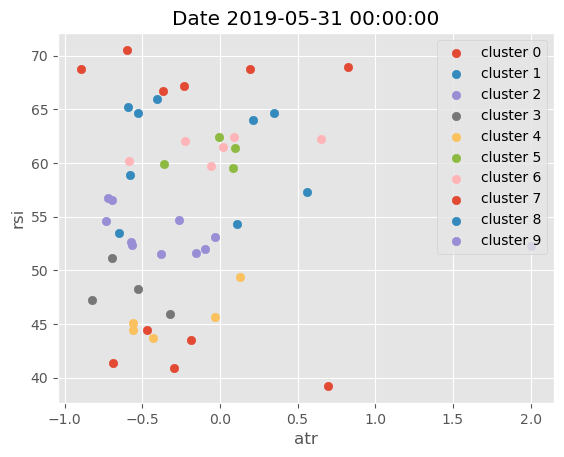

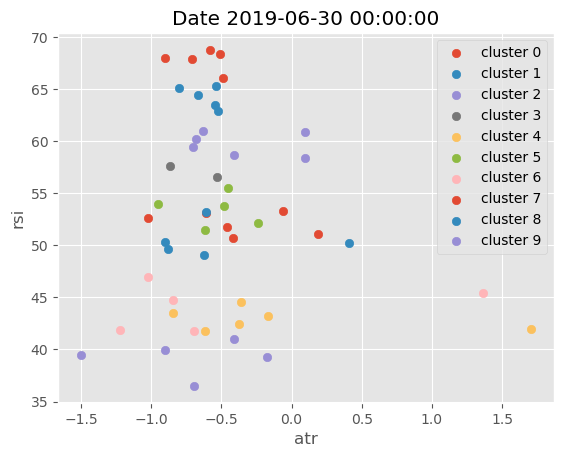

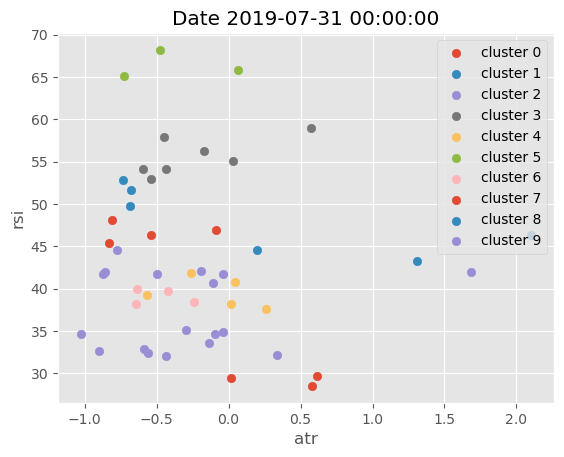

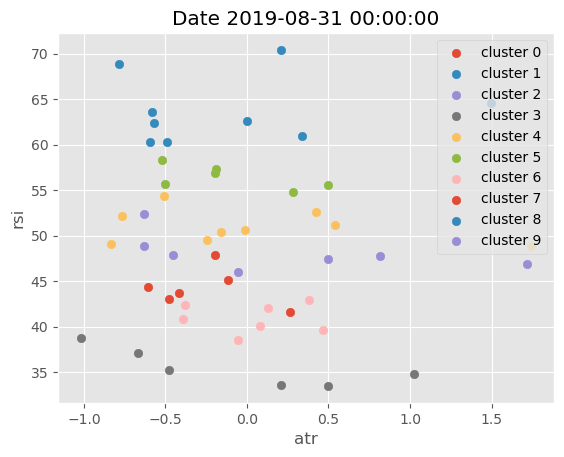

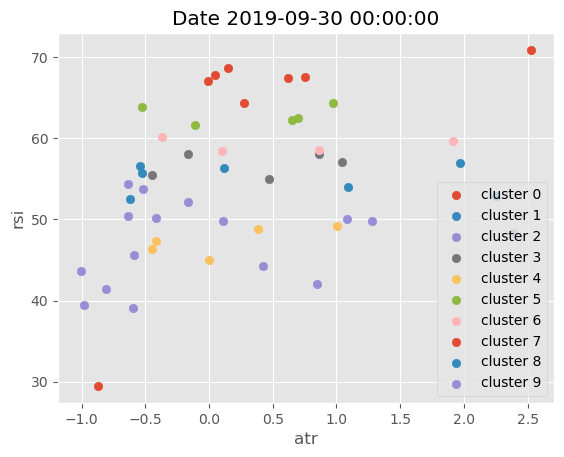

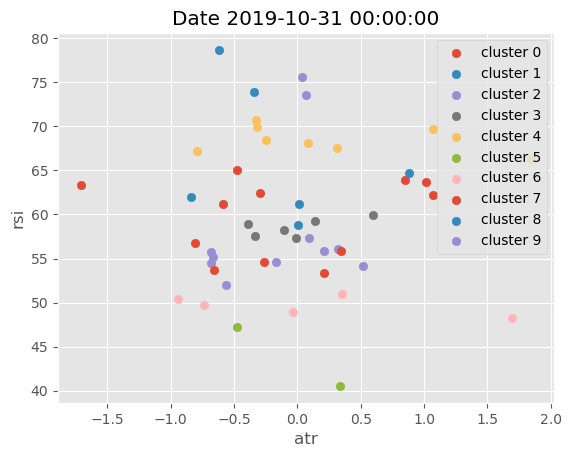

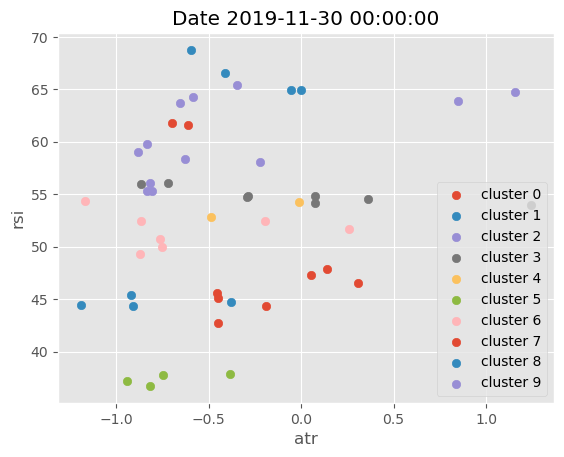

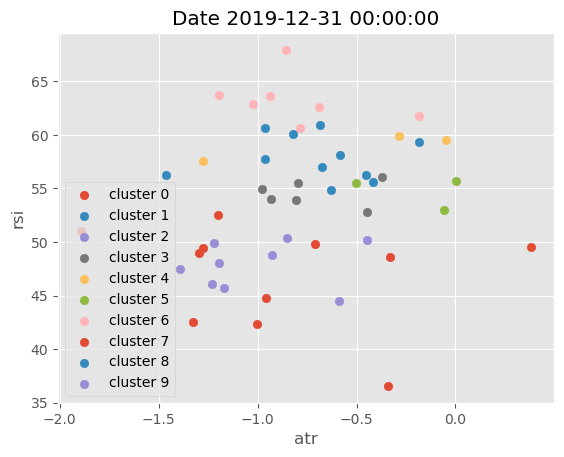

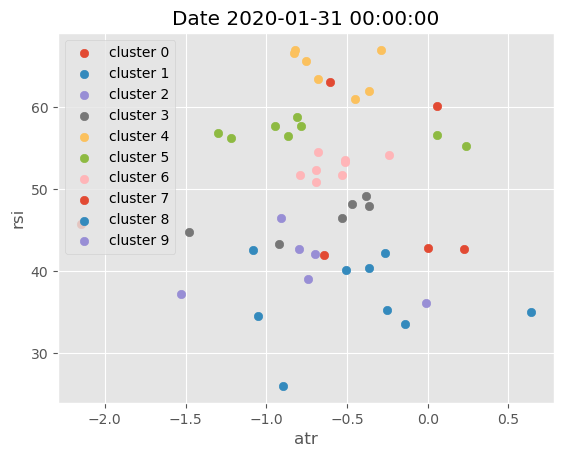

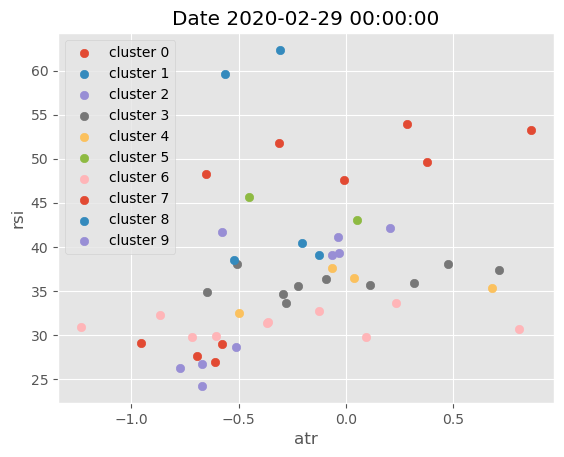

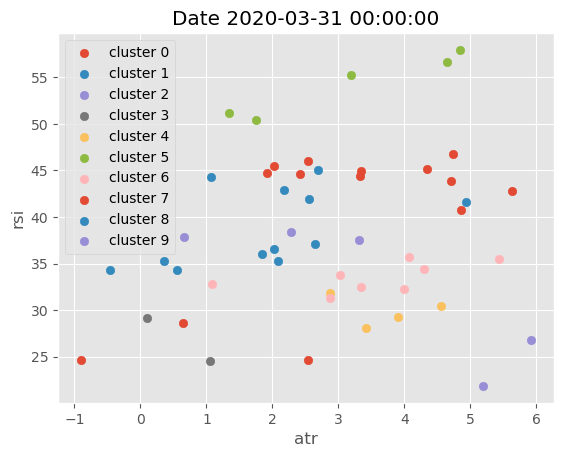

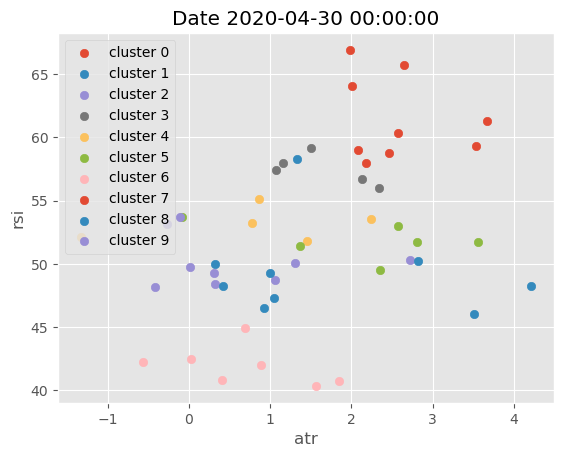

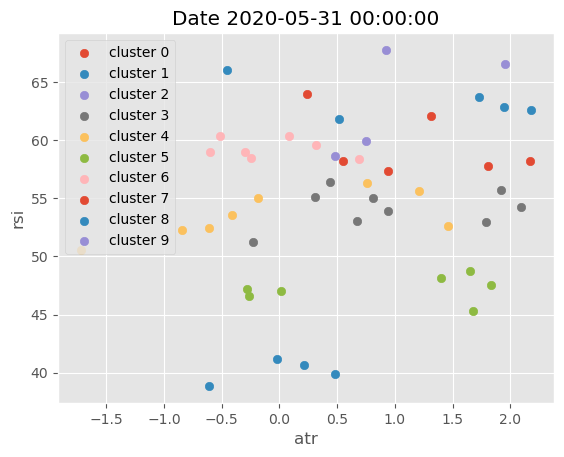

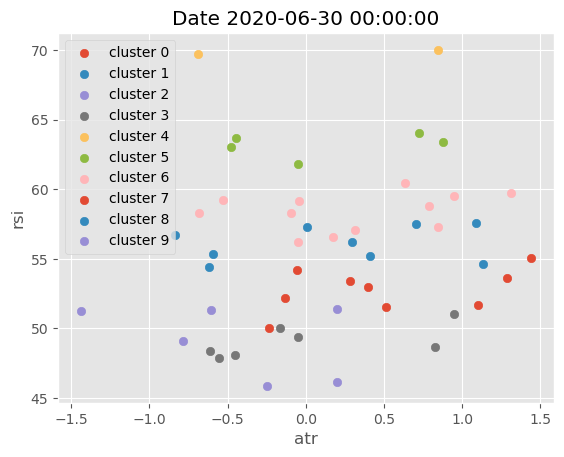

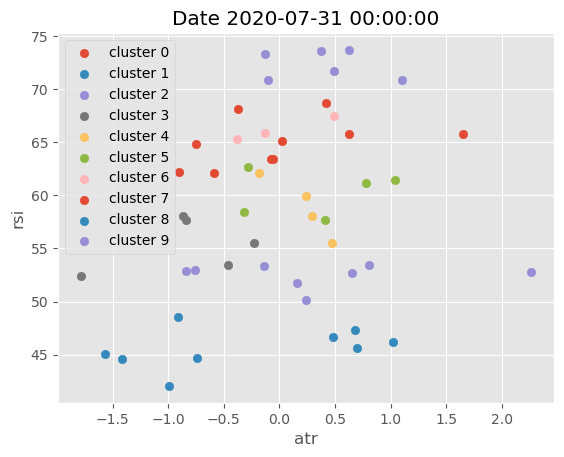

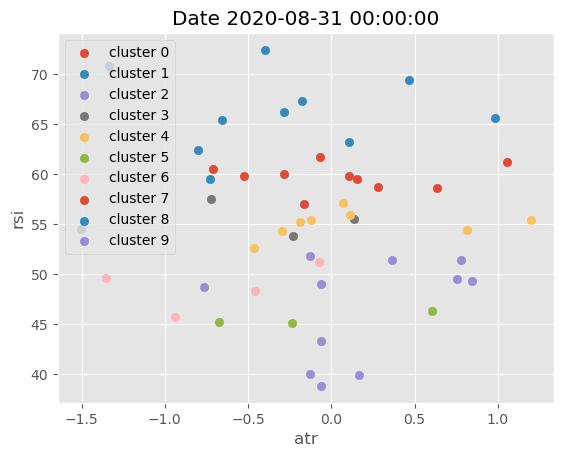

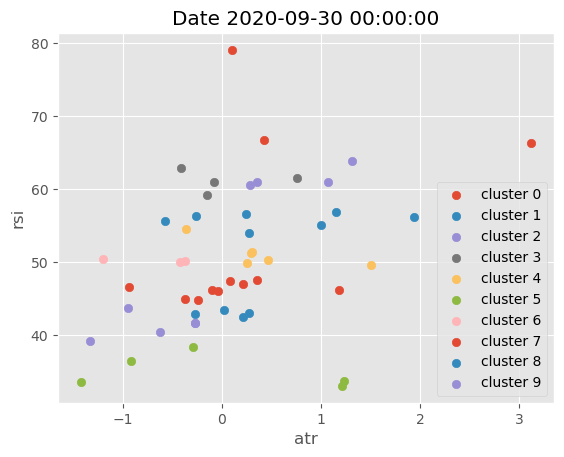

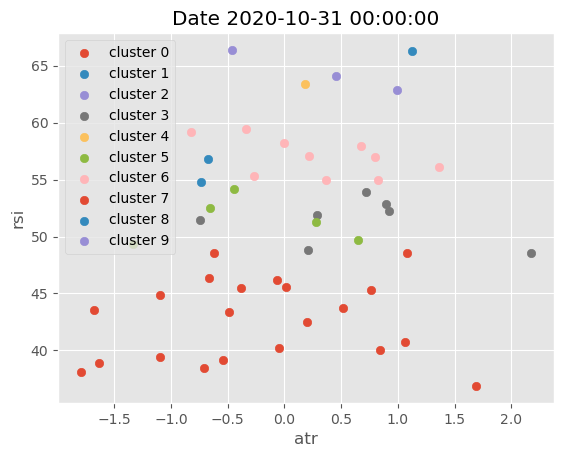

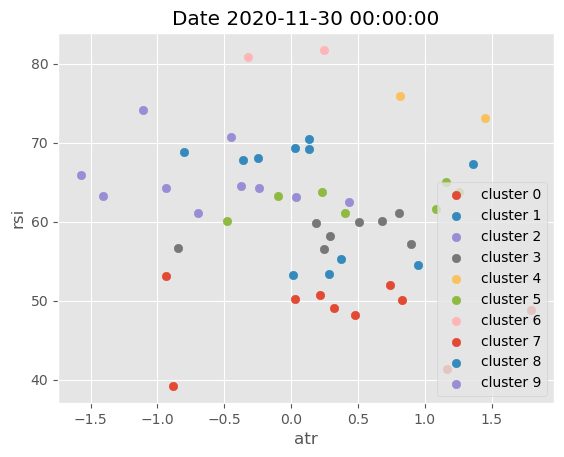

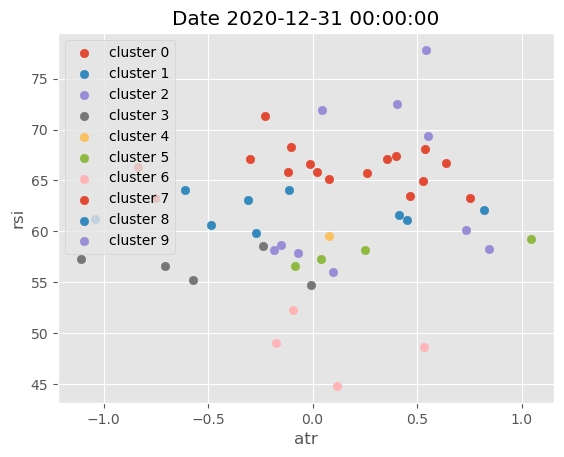

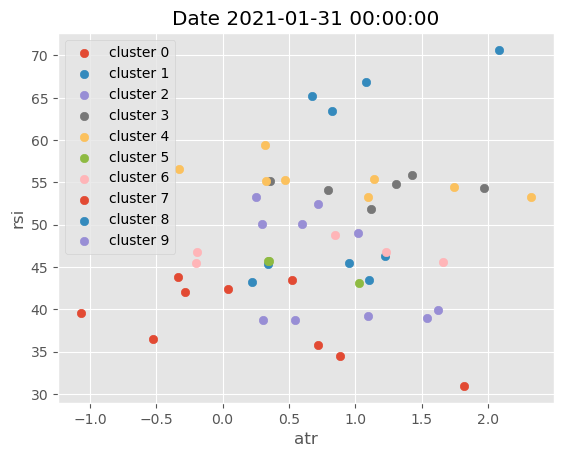

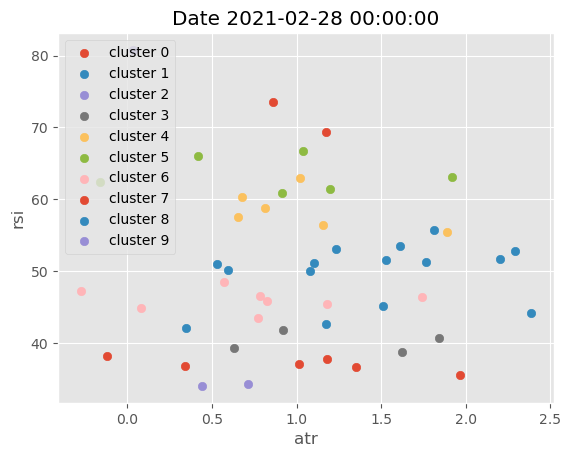

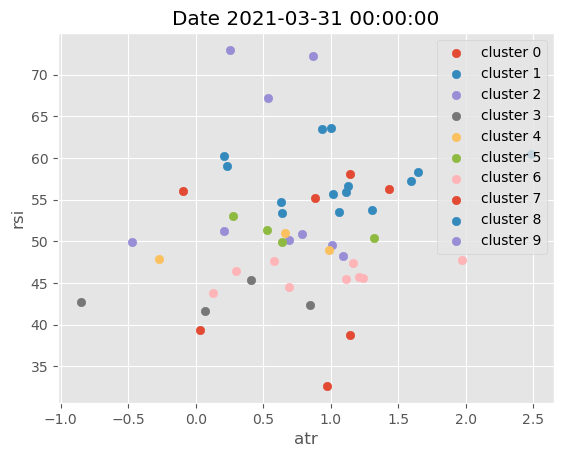

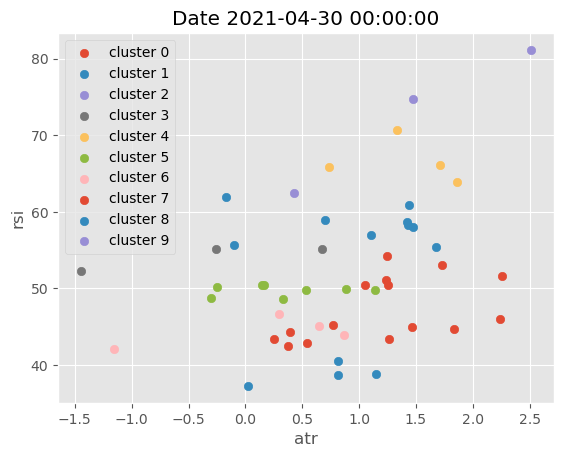

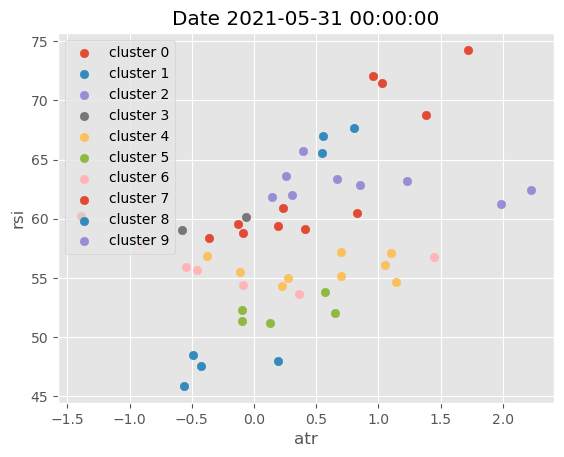

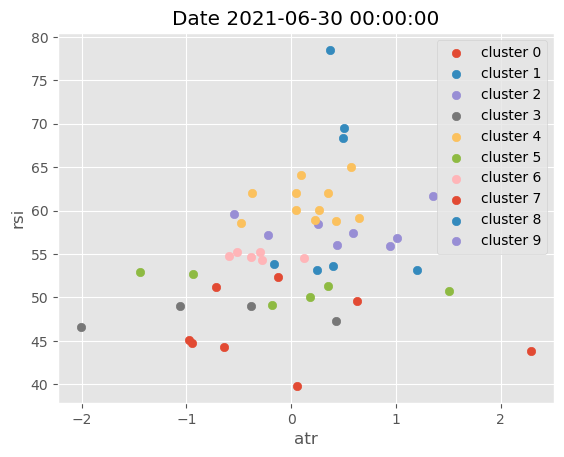

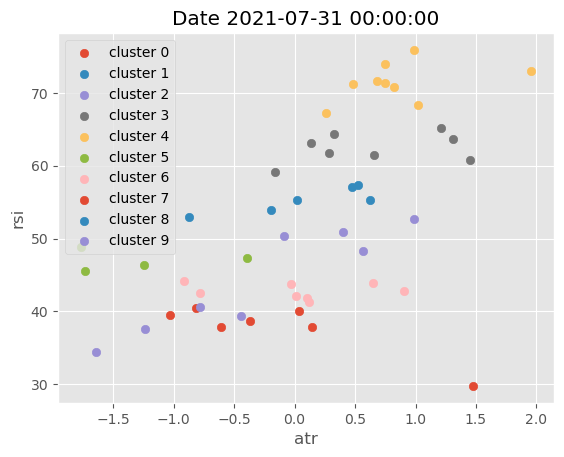

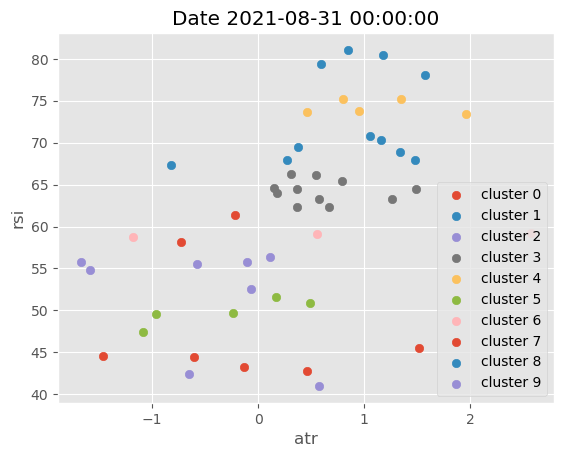

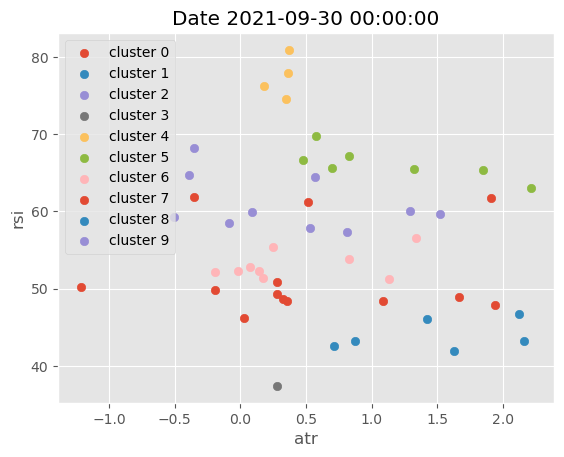

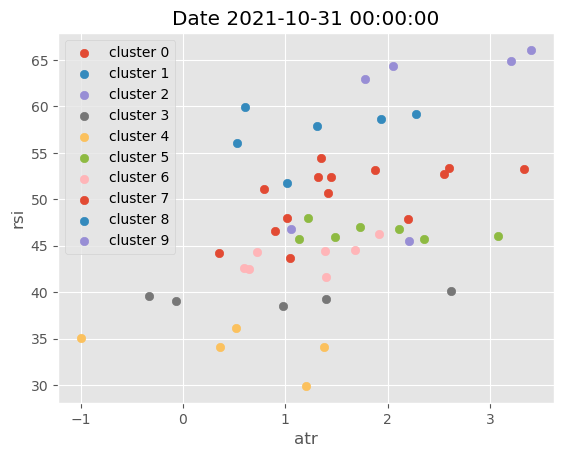

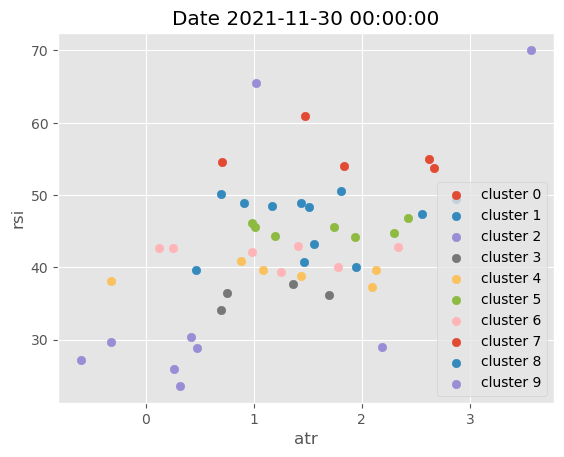

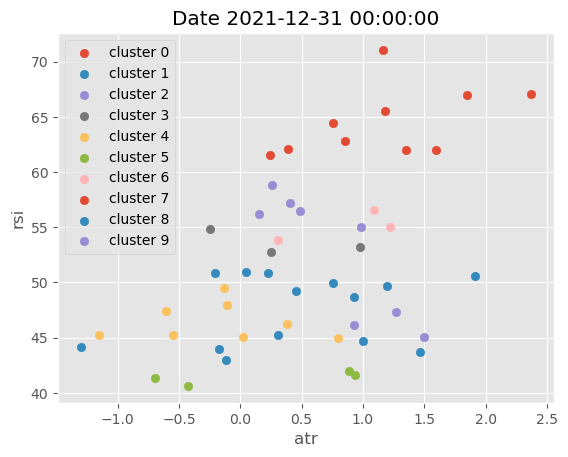

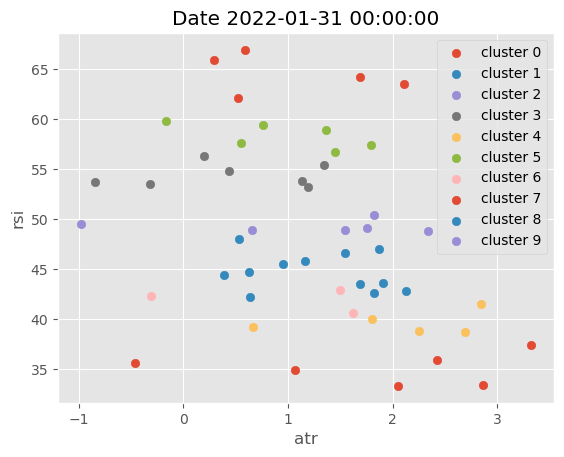

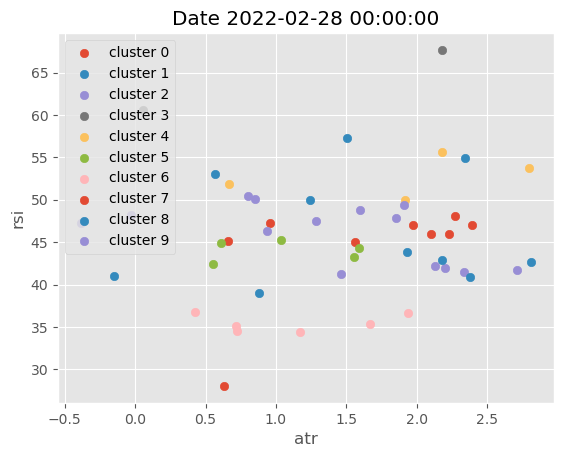

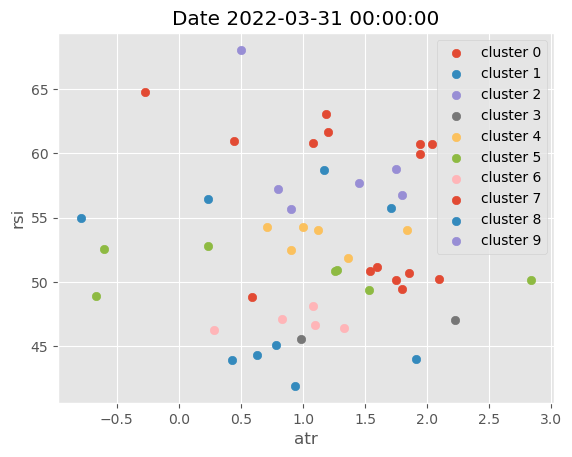

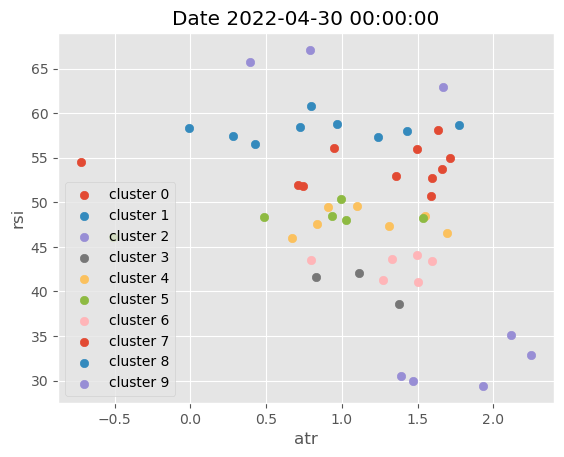

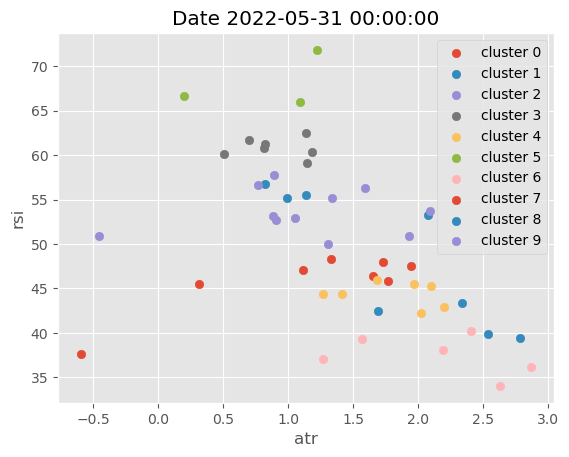

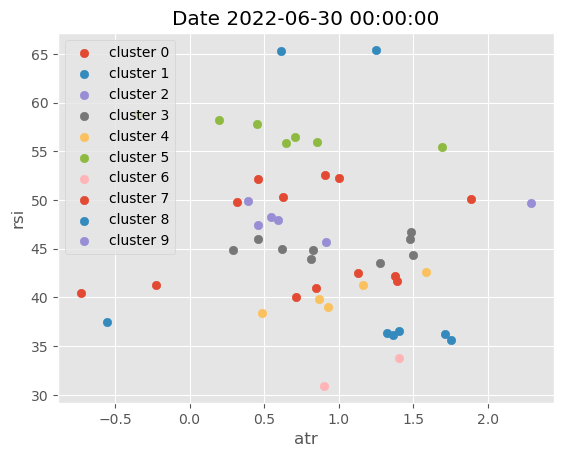

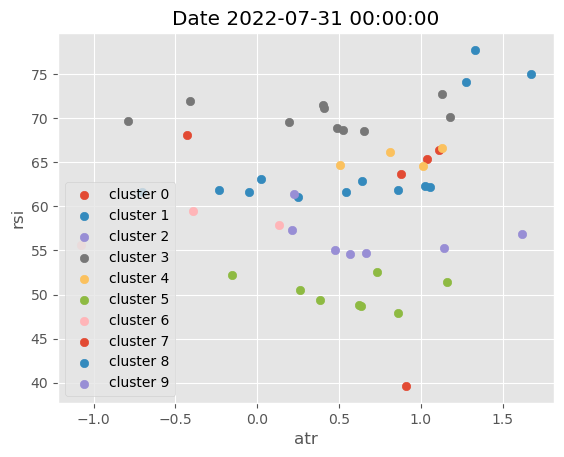

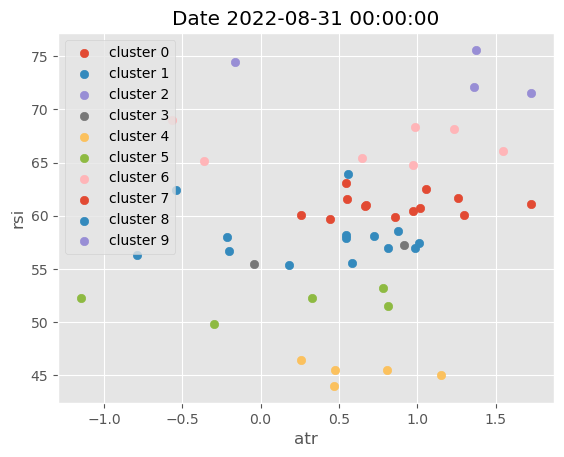

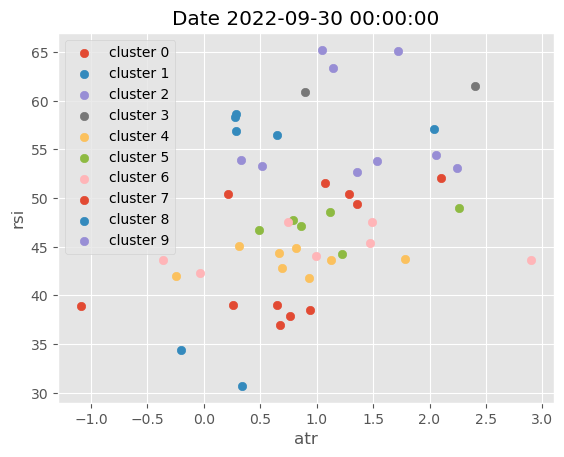

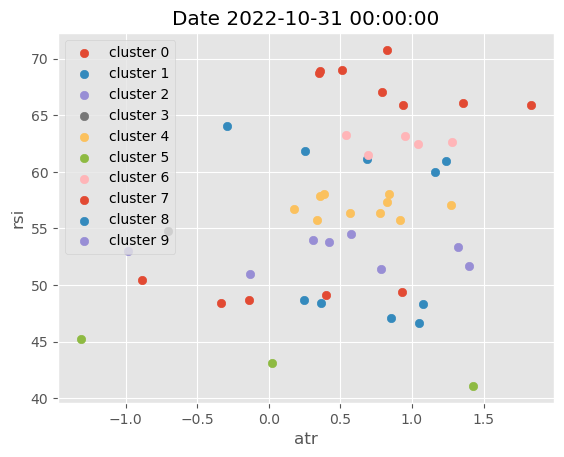

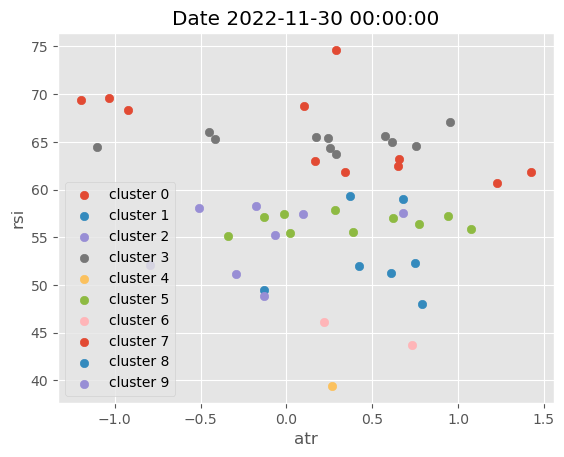

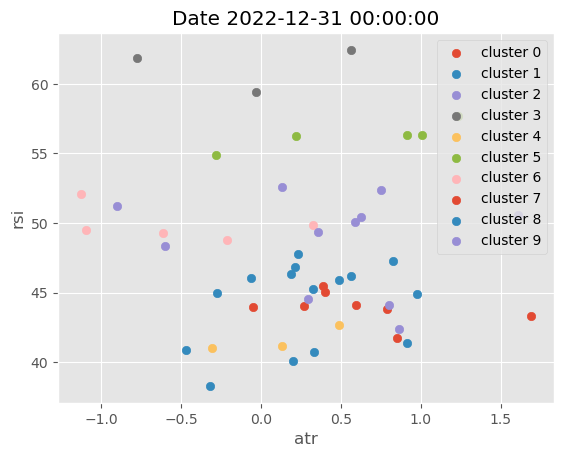

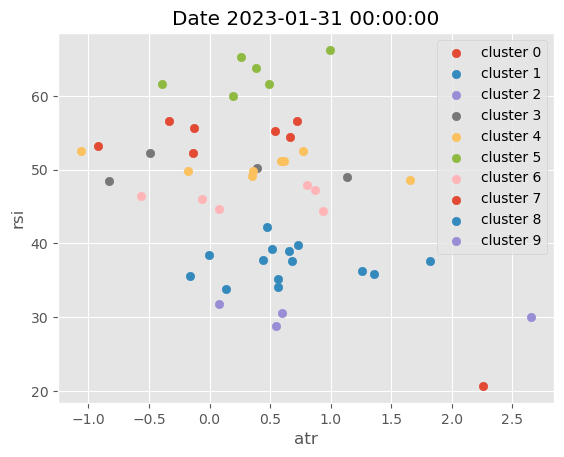

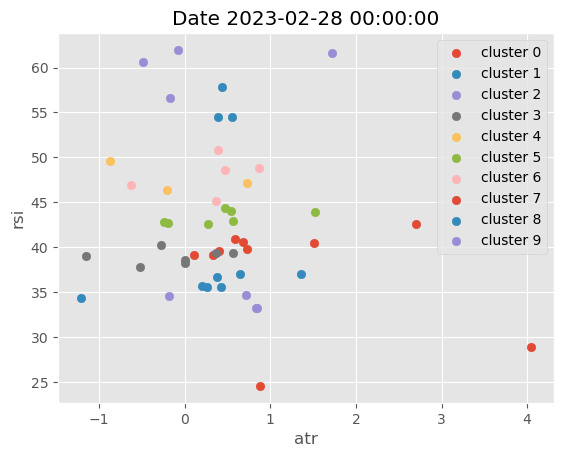

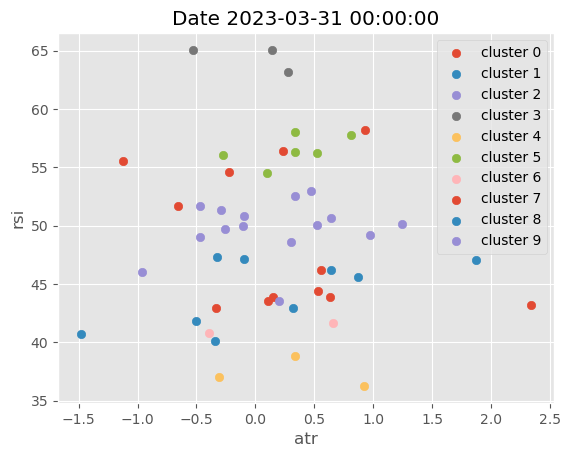

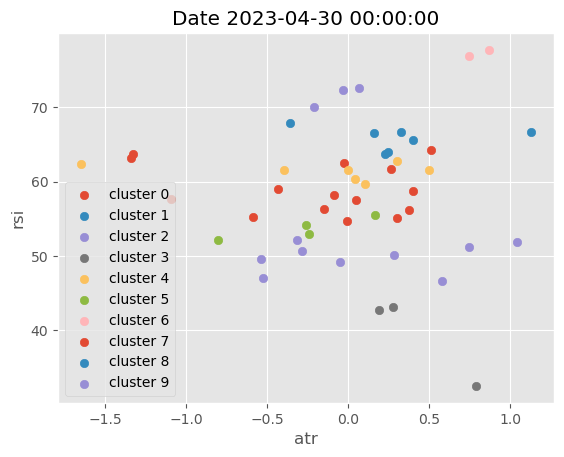

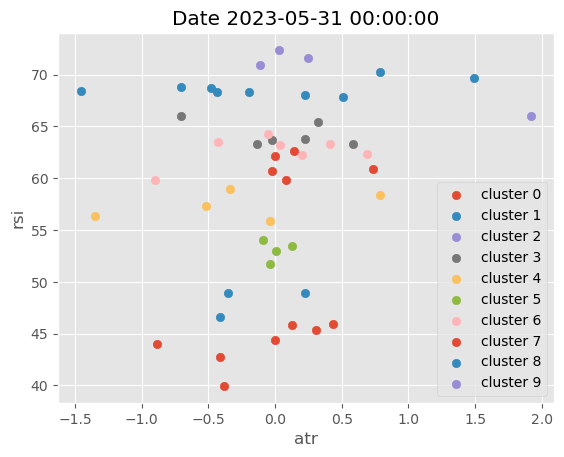

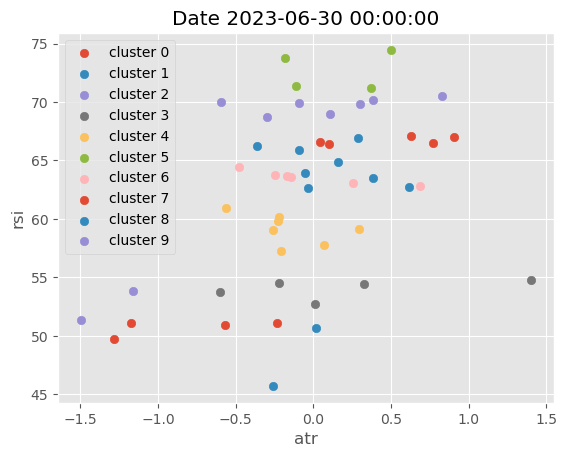

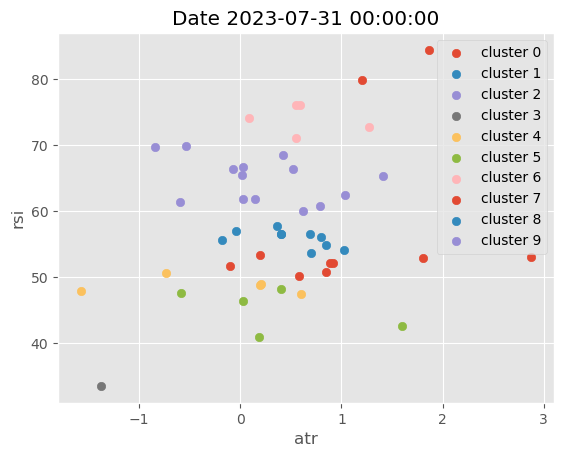

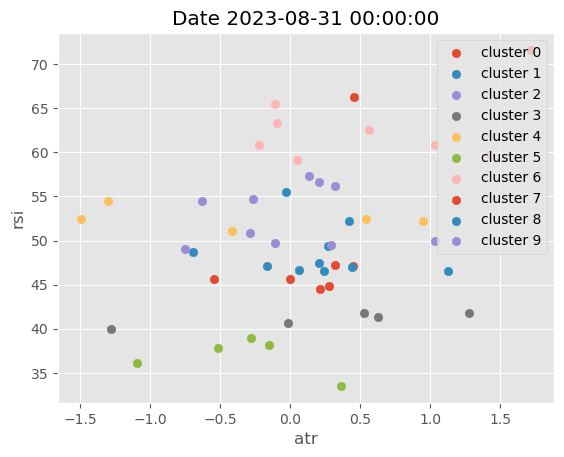

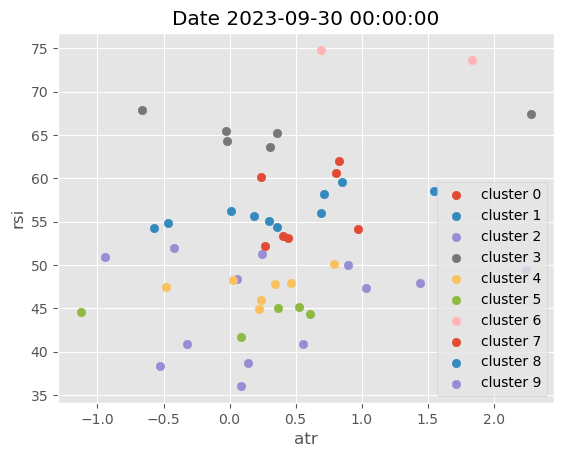

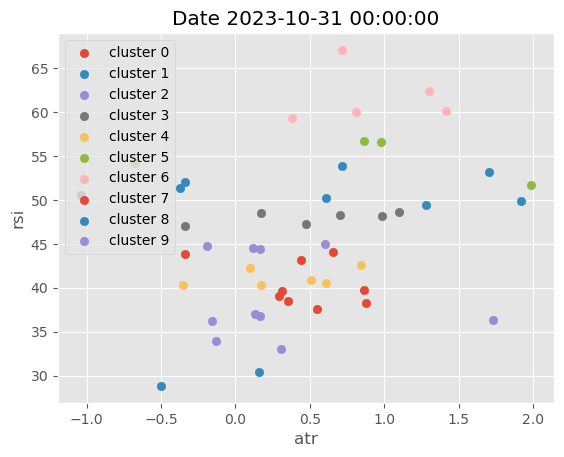

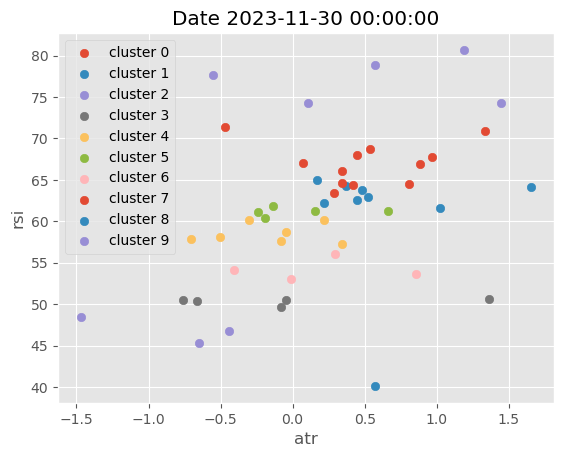

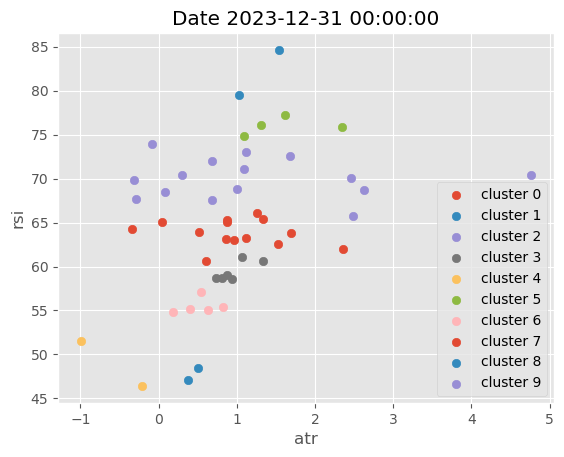

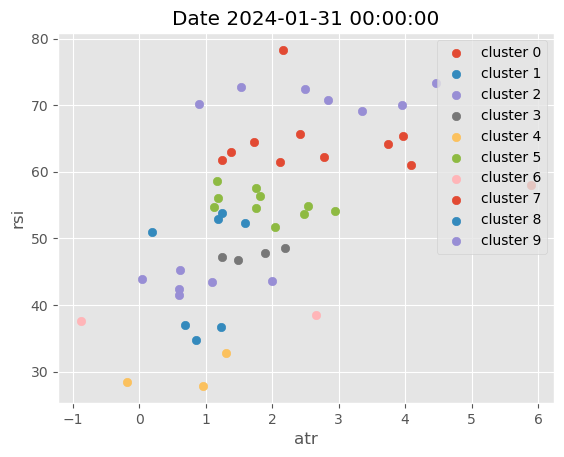

In [15]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

##  Apply pre-defined Centriods

In [16]:
target_rsi_values = [30,35,40,45,55,60,65,70,75,80]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 1] = target_rsi_values

initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 35.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 40.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 60.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 65.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 75.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 80.,  0.,  0.,  0.,  0.,

In [17]:
 

data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=10,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid  \
date       ticker                                                           
2017-03-31 ADANIENT.NS            0.001078  67.437649  3.917253  4.005770   
           ADANIPORTS.NS         -0.000675  68.082250  5.645352  5.722332   
           APOLLOHOSP.NS          0.000036  39.940303  7.013172  7.068295   
           ASIANPAINT.NS         -0.000628  61.406707  6.874274  6.915546   
           AXISBANK.NS            0.000067  47.576609  6.165180  6.210532   
...                                    ...        ...       ...       ...   
2024-01-31 TECHM.NS               0.000183  54.497785  7.091318  7.171500   
           TITAN.NS               0.000454  54.893945  8.200865  8.228010   
           ULTRACEMCO.NS          0.000295  53.623622  9.177835  9.210025   
           UPL.NS                 0.000234  37.605205  6.264742  6.331110   
           WIPRO.NS               0.000279  57.631865  6.091774  6.149844   

                           bb_high       atr      macd  return_1m  return_2m  \
date       ticker                                                              
2017-03-31 ADANIENT.NS    4.094287 -0.722817 -0.123147   0.102030   0.116044   
           ADANIPORTS.NS  5.799313 -0.934239  0.298638   0.125435   0.075947   
           APOLLOHOSP.NS  7.123417 -1.036850 -0.618353  -0.104867  -0.026739   
           ASIANPAINT.NS  6.956817 -1.190762  0.191916   0.048135   0.051619   
           AXISBANK.NS    6.255885 -0.962747 -0.241542  -0.031284   0.026264   
...                            ...       ...       ...        ...        ...   
2024-01-31 TECHM.NS       7.251681  1.752537  1.201057   0.035516   0.038925   
           TITAN.NS       8.255155  2.542950  1.215169   0.016406   0.034520   
           ULTRACEMCO.NS  9.242216  2.477912  0.522390  -0.051361   0.051959   
           UPL.NS         6.397477 -0.881272 -1.013769  -0.088548  -0.031514   
           WIPRO.NS       6.207914  1.757520  1.123383   0.004684   0.070686   

                          return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                       
2017-03-31 ADANIENT.NS     0.123470   0.087287   0.025222    0.032677   
           ADANIPORTS.NS   0.081520   0.047714   0.056632    0.026645   
           APOLLOHOSP.NS  -0.004185  -0.019764  -0.013395   -0.010923   
           ASIANPAINT.NS   0.064061  -0.012524   0.007820    0.018488   
           AXISBANK.NS     0.029390  -0.016205  -0.008201    0.009140   
...                             ...        ...        ...         ...   
2024-01-31 TECHM.NS        0.055387   0.030012   0.035645    0.027347   
           TITAN.NS        0.054091   0.036999   0.039621    0.038669   
           ULTRACEMCO.NS   0.057619   0.030540   0.031730    0.029205   
           UPL.NS         -0.003248  -0.022779  -0.033647   -0.027175   
           WIPRO.NS        0.074394   0.026368   0.023258    0.014401   

                            Mkt-RF       SMB       HML       RMW       CMA  \
date       ticker                                                            
2017-03-31 ADANIENT.NS    0.398289 -0.546472  0.397581  1.890638 -0.500539   
           ADANIPORTS.NS  0.230175  0.116486  0.497220  0.328945 -0.651044   
           APOLLOHOSP.NS  0.374700 -0.416517  0.233335 -0.188432 -1.379052   
           ASIANPAINT.NS  0.118651  0.161033  0.189737  0.408256 -0.256290   
           AXISBANK.NS    0.849098  0.214726  0.408220 -0.414940  0.043711   
...                            ...       ...       ...       ...       ...   
2024-01-31 TECHM.NS       0.688300 -0.488224  0.325515 -0.474993 -0.702060   
           TITAN.NS       0.358524  0.203554  0.376473  0.758710 -0.028387   
           ULTRACEMCO.NS  0.351529 -0.141420  0.691142  0.243236 -1.452401   
           UPL.NS         0.596278  0.212544  0.269222  0.633518  0.573136   
           WIPRO.NS       0.486848 -0.317518  0.274310 -0.066630 -0.630498   

                  

In [18]:
# def plot_clusters(data):

#     cluster_0 = data[data['cluster']==0]
#     cluster_1 = data[data['cluster']==1]
#     cluster_2 = data[data['cluster']==2]
#     cluster_3 = data[data['cluster']==3]

#     plt.scatter(cluster_0.iloc[:,5] , cluster_0.iloc[:,1] , color = 'red', label='cluster 0')
#     plt.scatter(cluster_1.iloc[:,5] , cluster_1.iloc[:,1] , color = 'green', label='cluster 1')
#     plt.scatter(cluster_2.iloc[:,5] , cluster_2.iloc[:,1] , color = 'blue', label='cluster 2')
#     plt.scatter(cluster_3.iloc[:,5] , cluster_3.iloc[:,1] , color = 'black', label='cluster 3')

#     plt.legend()
#     plt.show()
#     return
import matplotlib.pyplot as plt

def plot_clusters(data, num_clusters=10):
    # Iterate over clusters
    for cluster_num in range(num_clusters):
        cluster_data = data[data['cluster'] == cluster_num]
        # Scatter plot for each cluster
        plt.scatter(cluster_data.iloc[:, 5], cluster_data.iloc[:, 1], label=f'cluster {cluster_num}')

    # Labeling
    x_label = data.columns[5]
    y_label = data.columns[1]
    plt.title(f'Clusters based on {x_label} and {y_label}')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()

# Example usage with 4 clusters
# Replace data and 'cluster' with your actual DataFrame and cluster column name
# plot_clusters(your_data_frame, num_clusters=4)


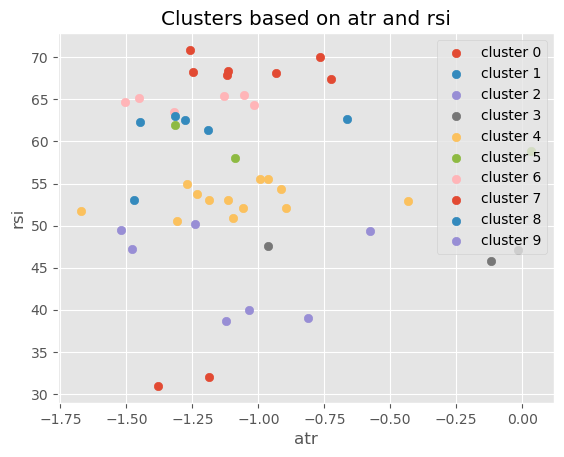

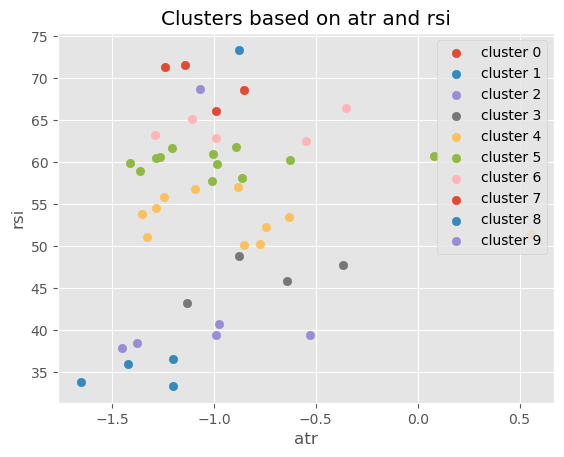

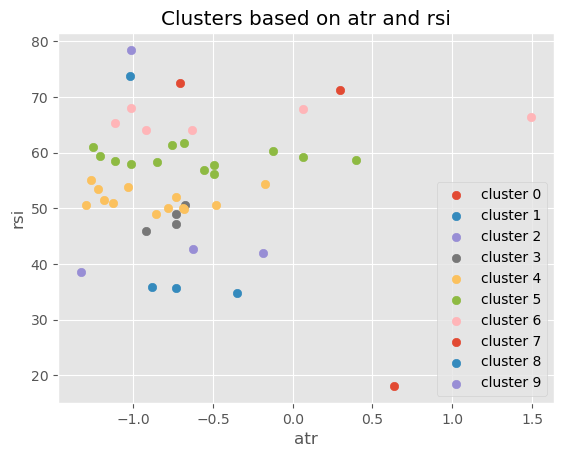

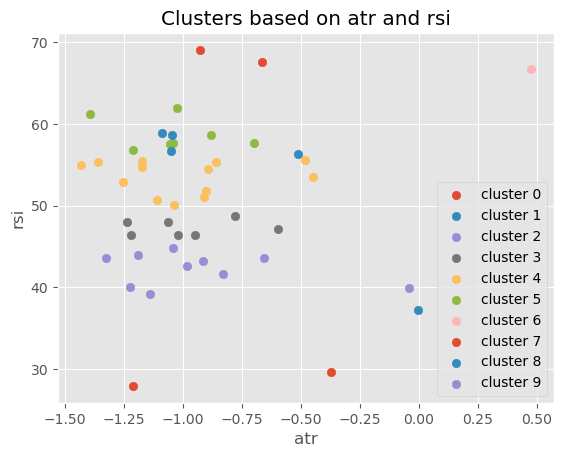

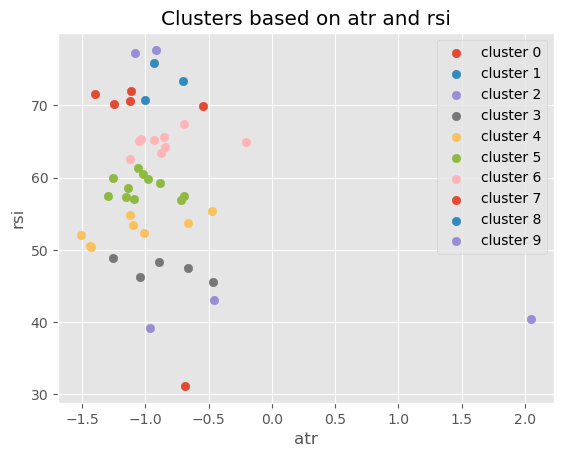

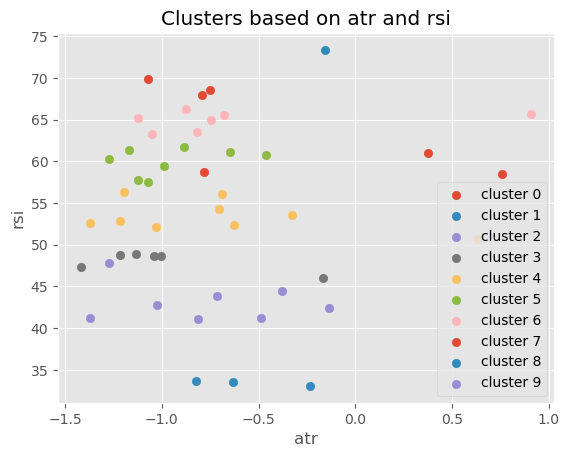

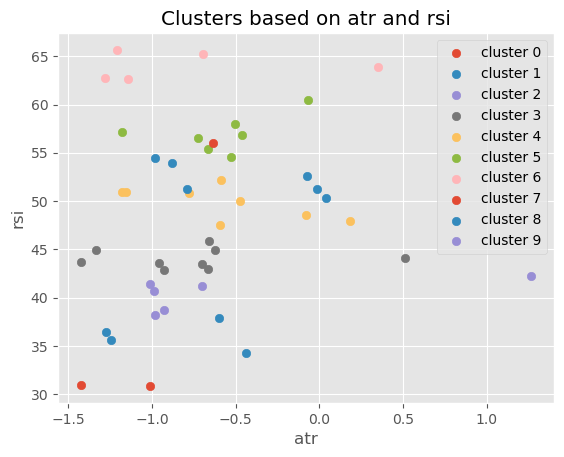

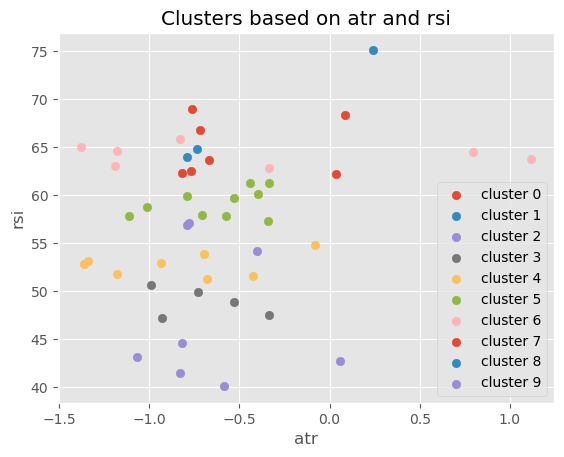

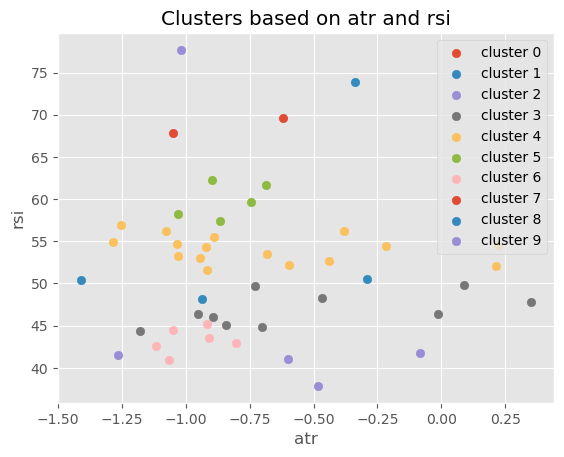

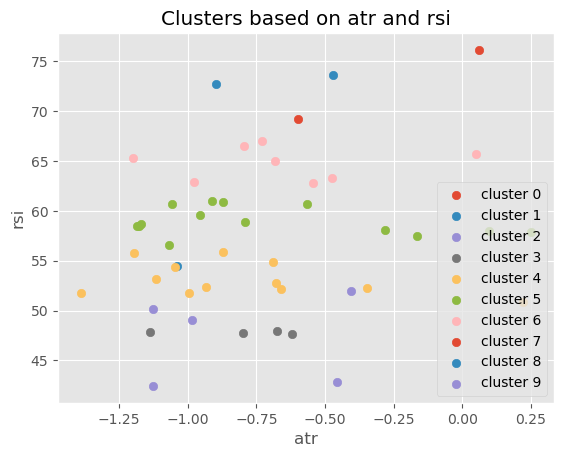

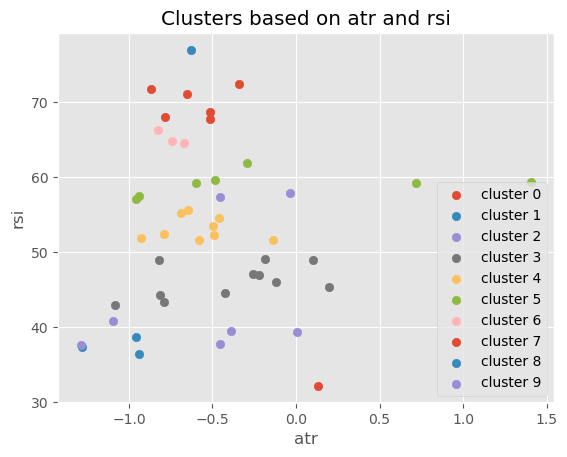

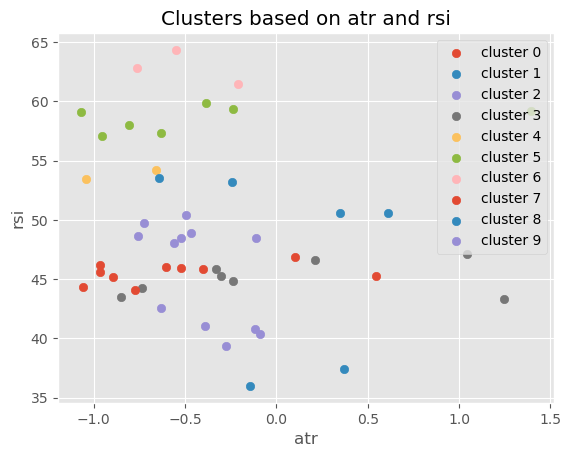

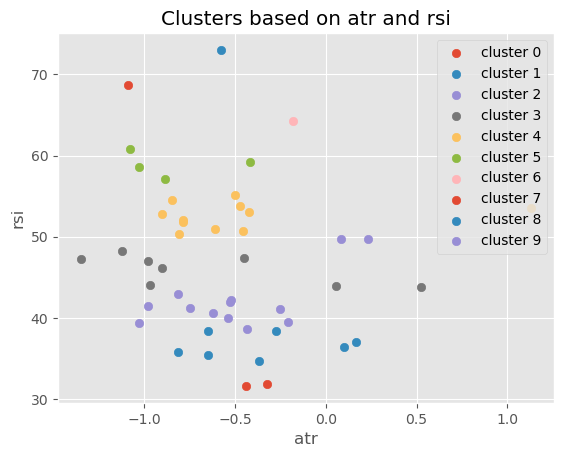

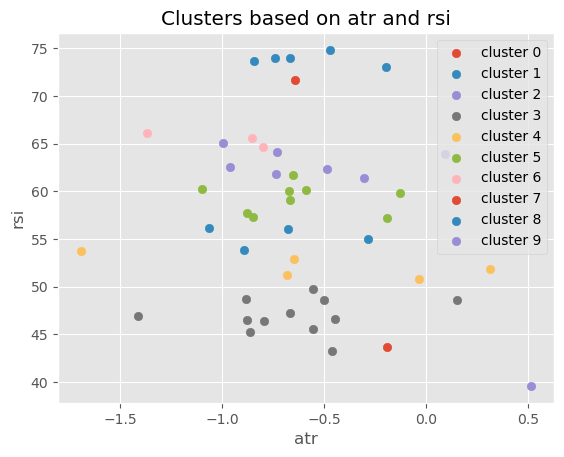

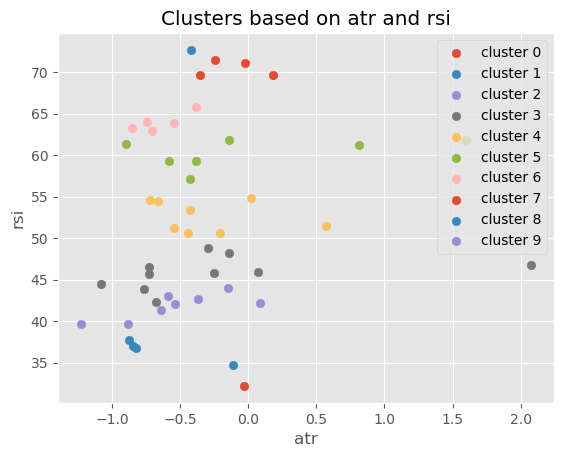

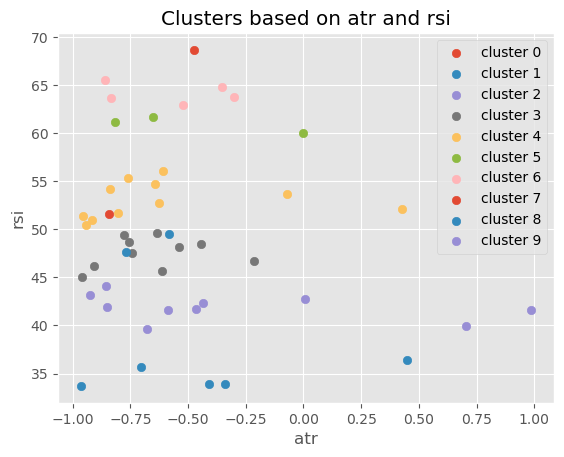

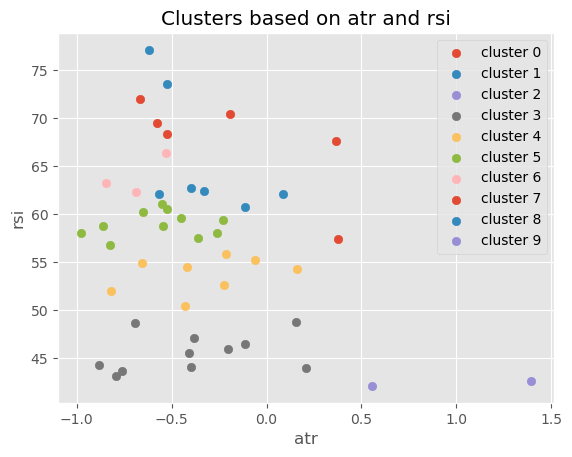

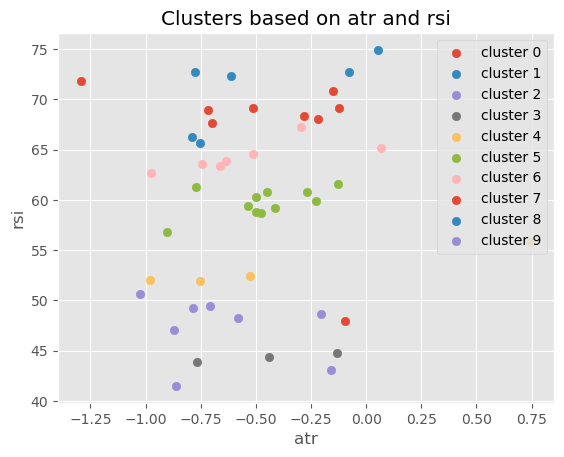

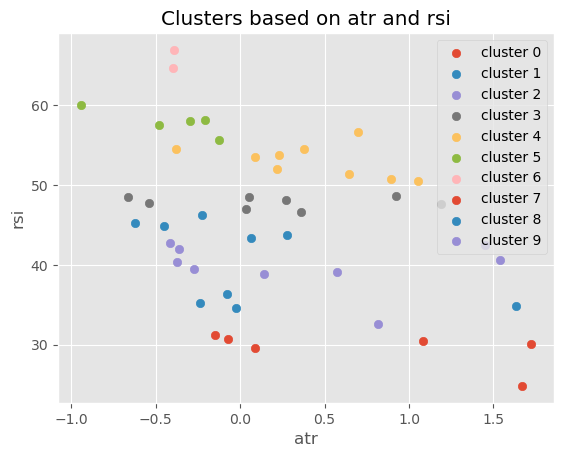

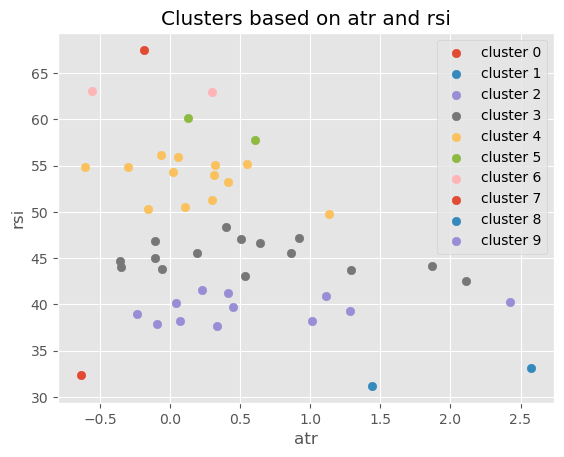

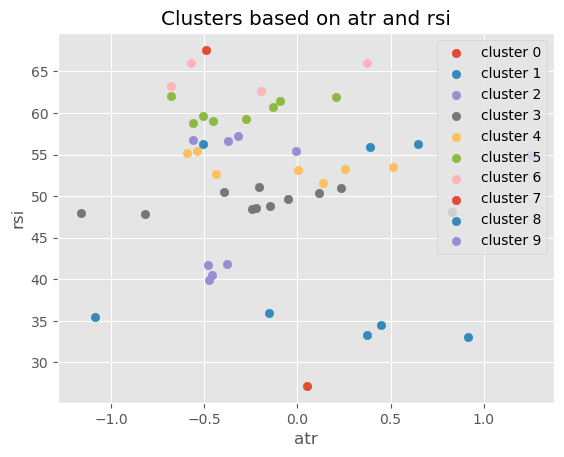

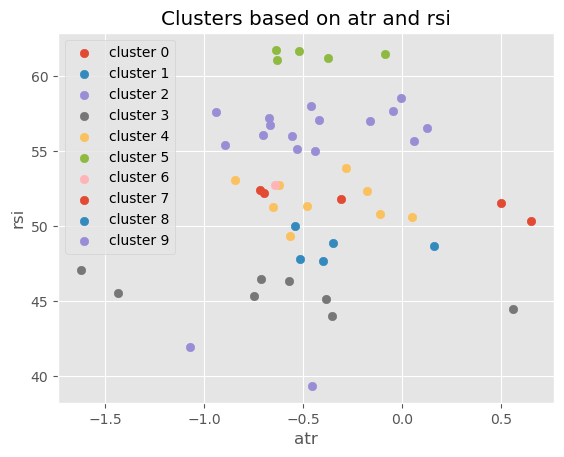

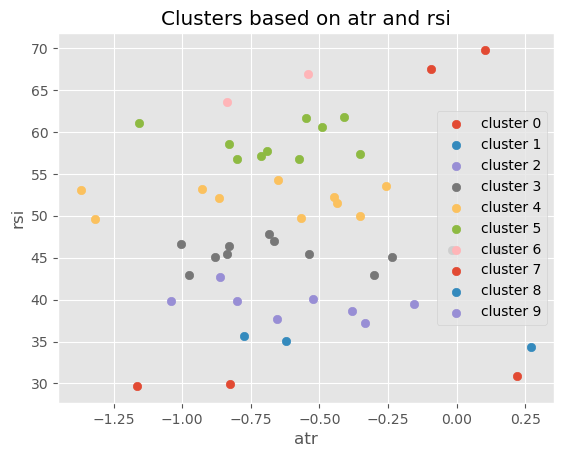

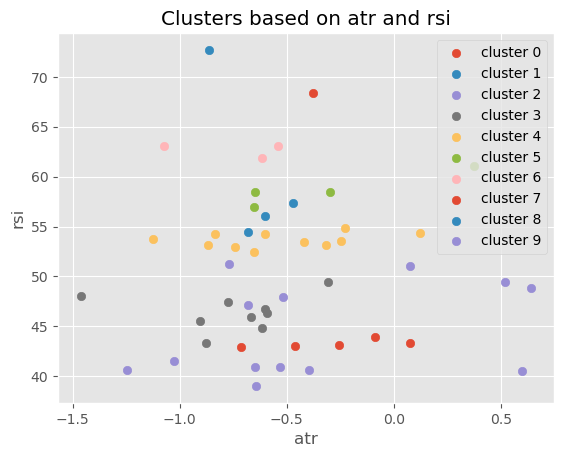

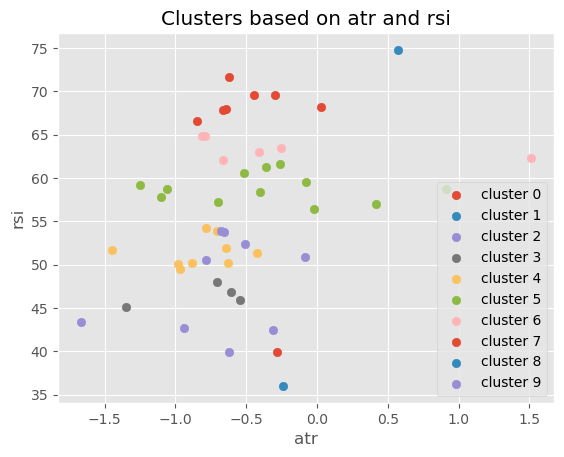

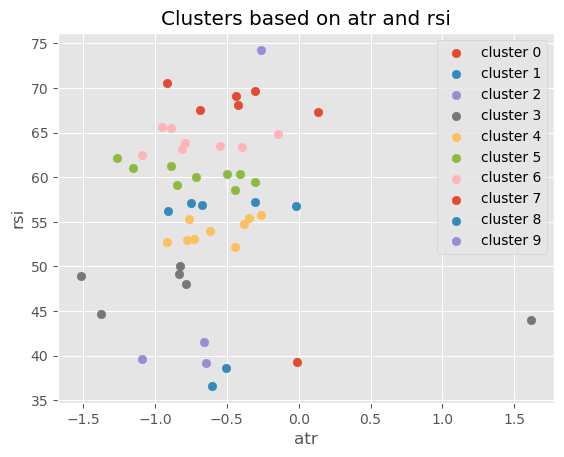

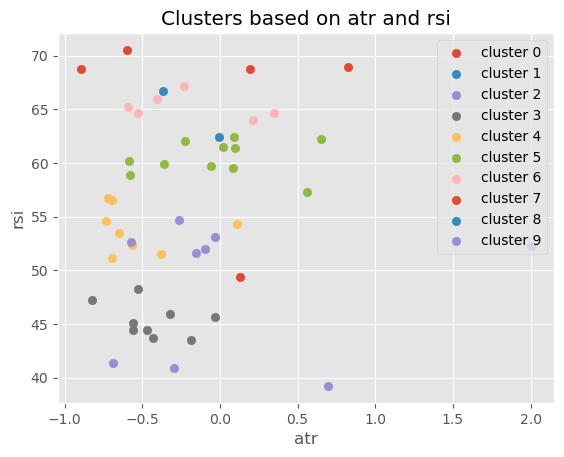

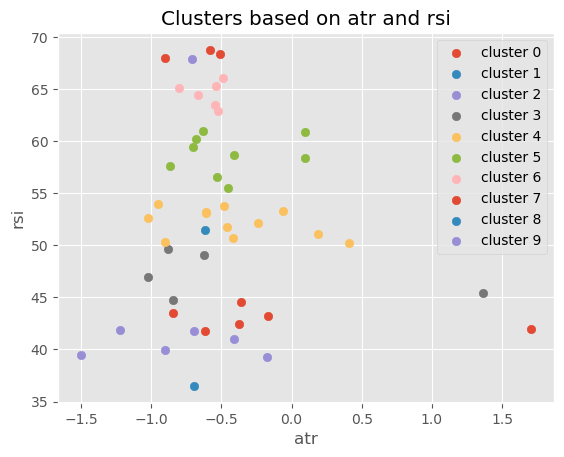

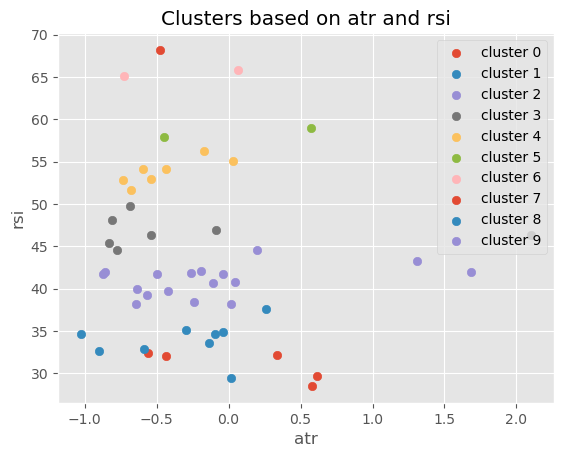

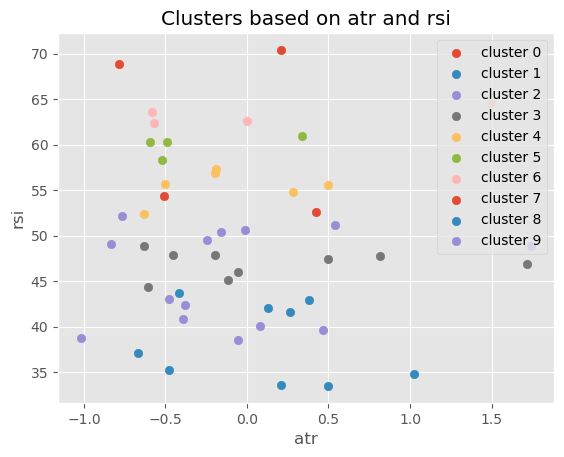

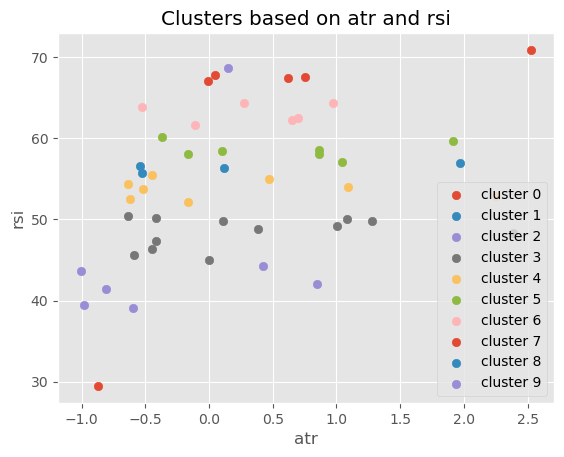

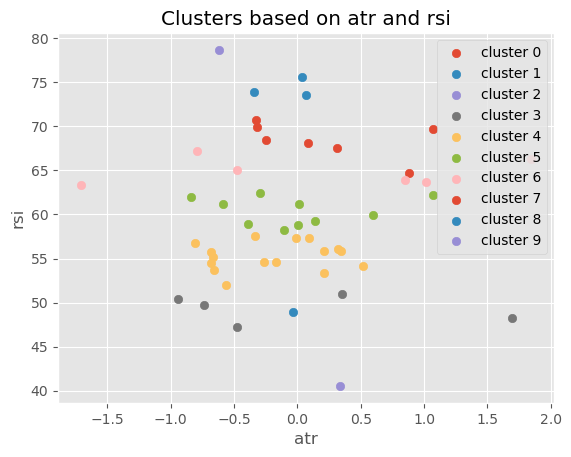

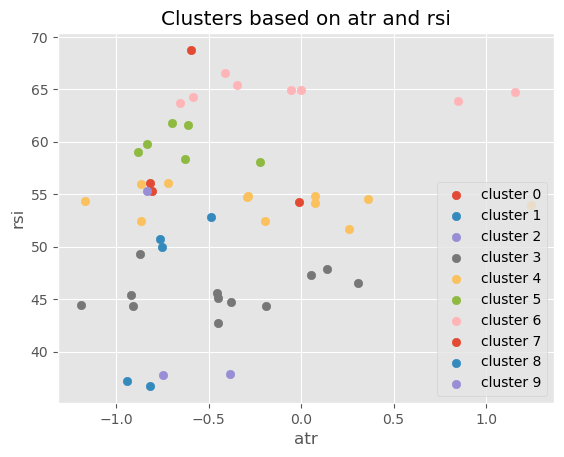

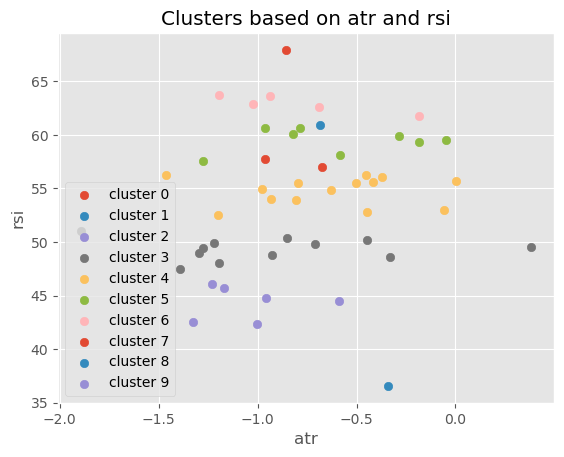

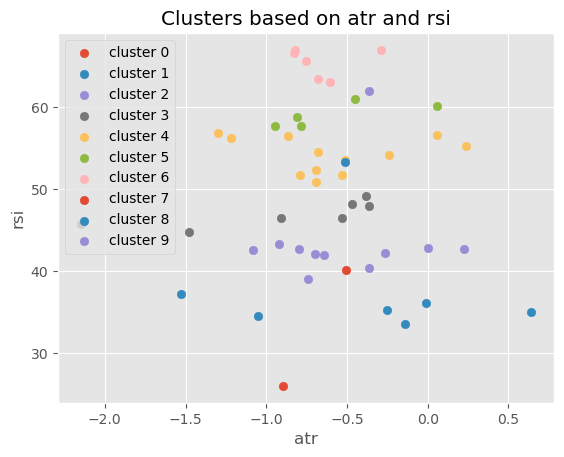

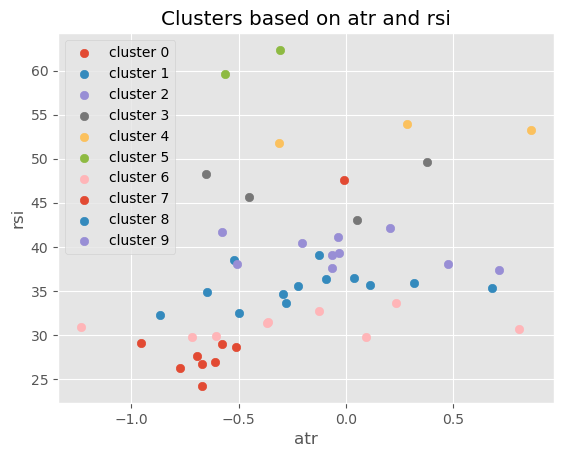

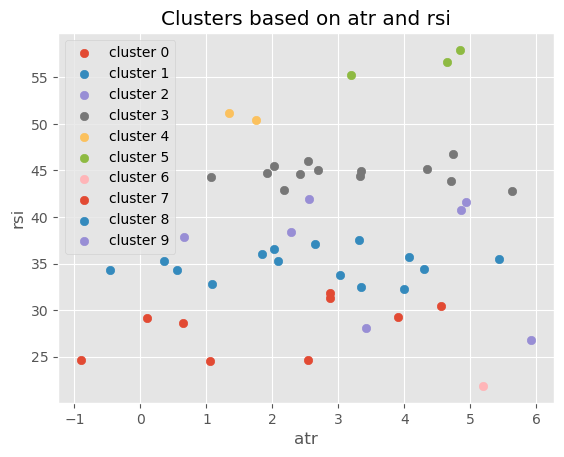

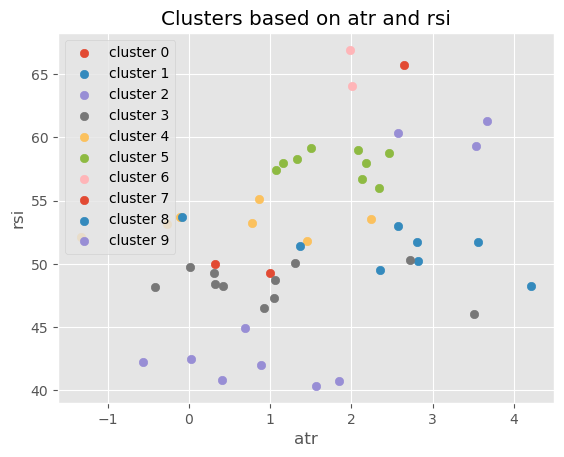

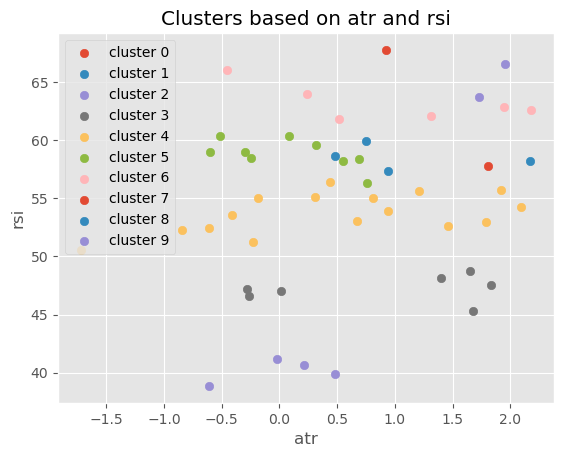

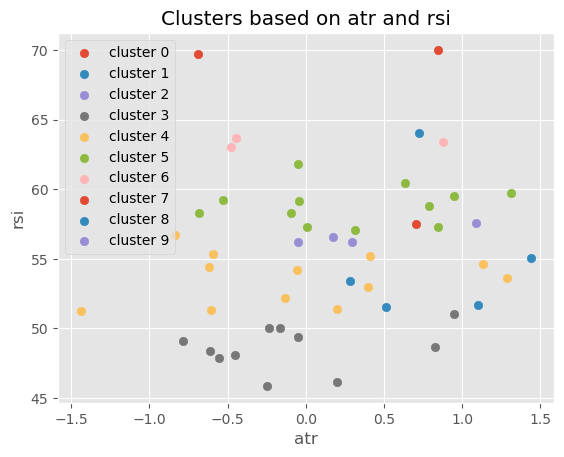

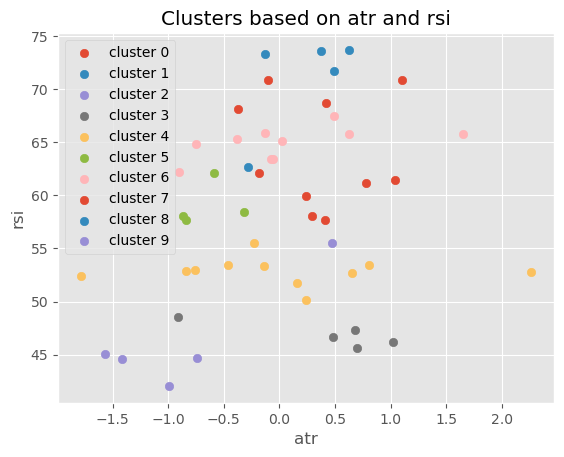

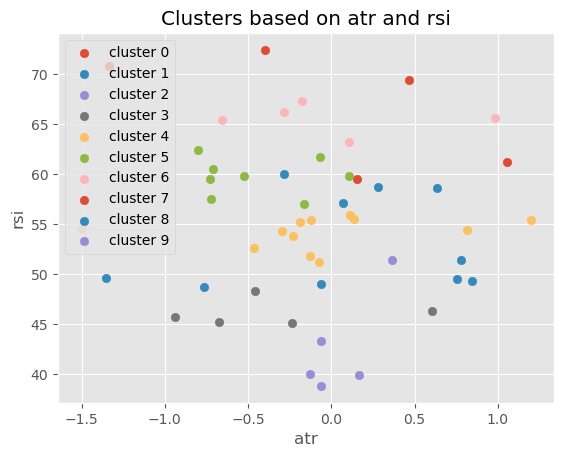

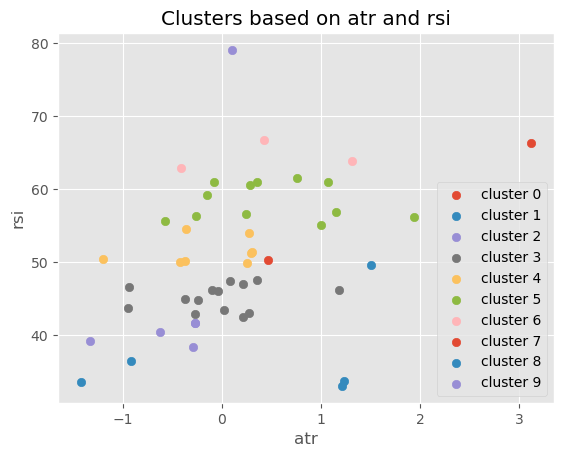

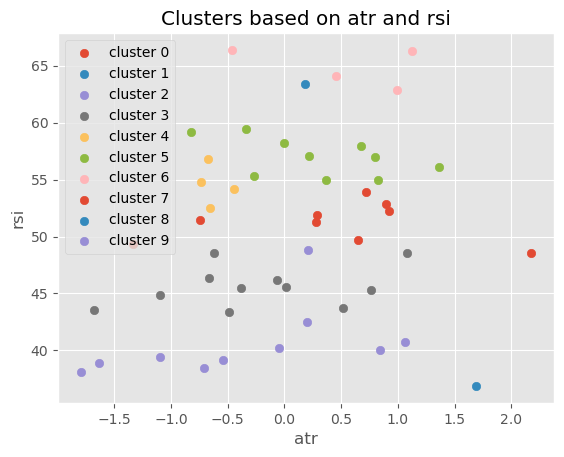

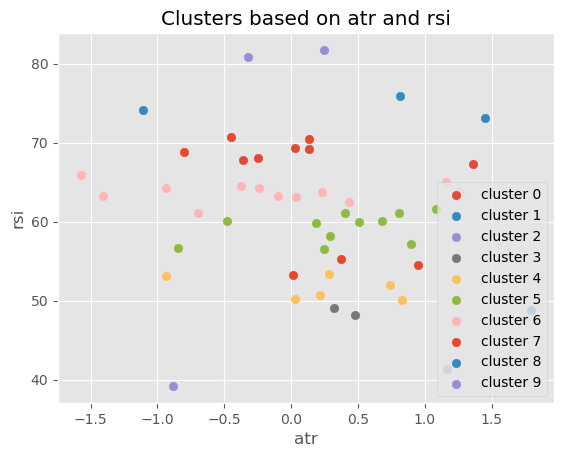

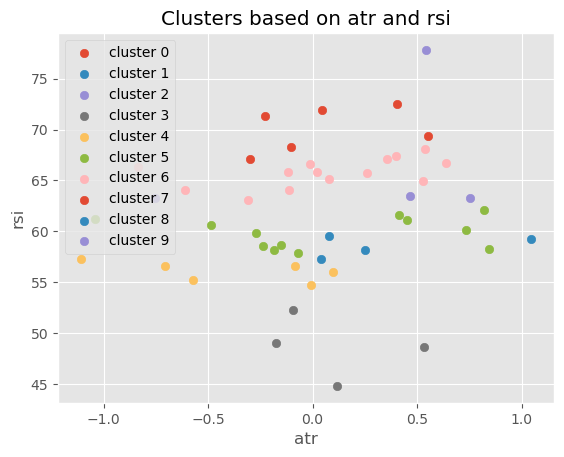

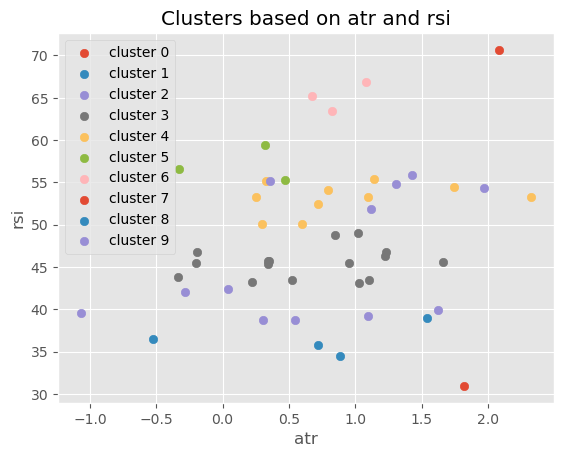

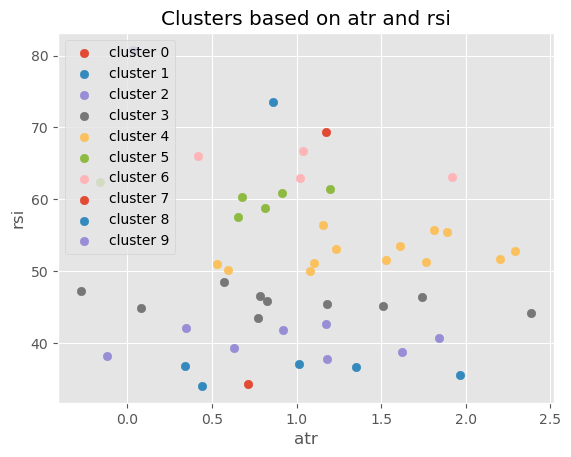

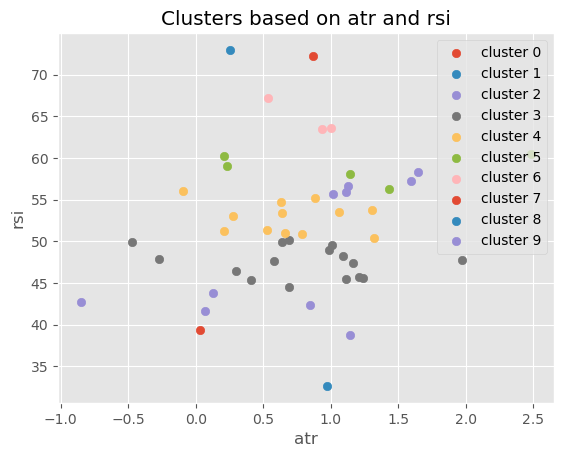

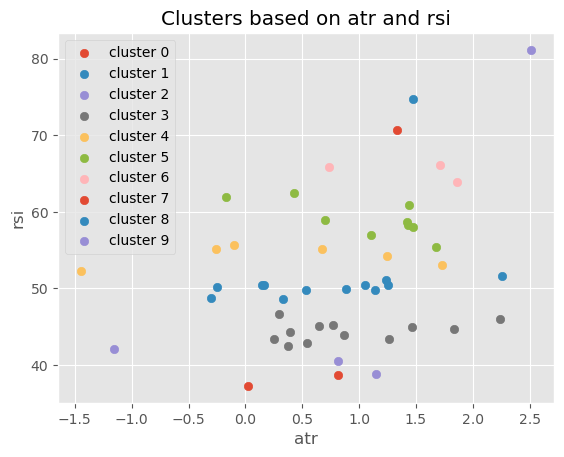

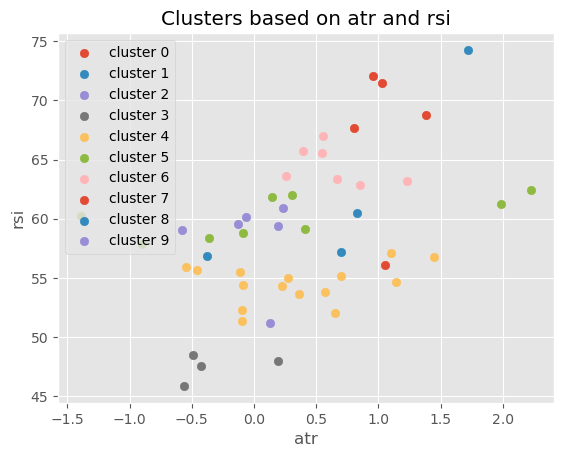

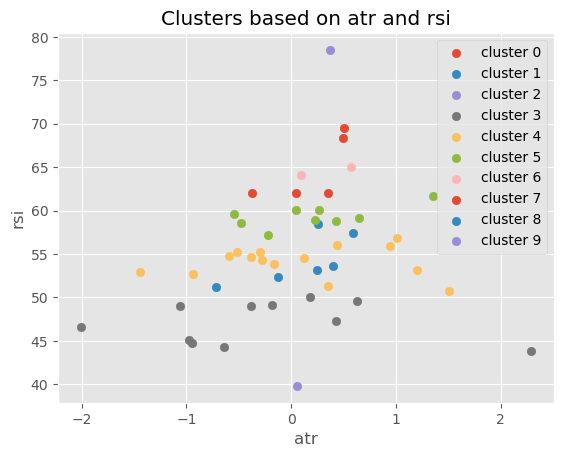

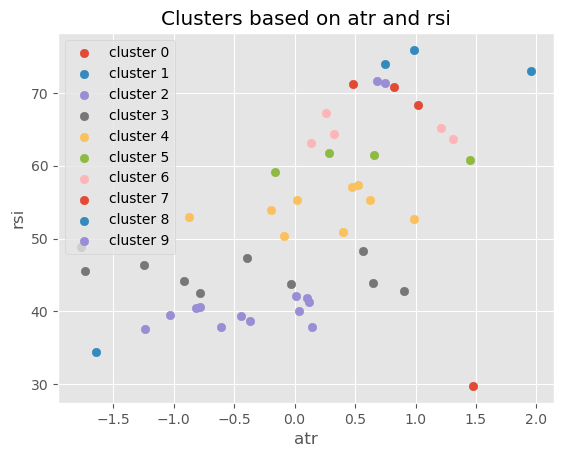

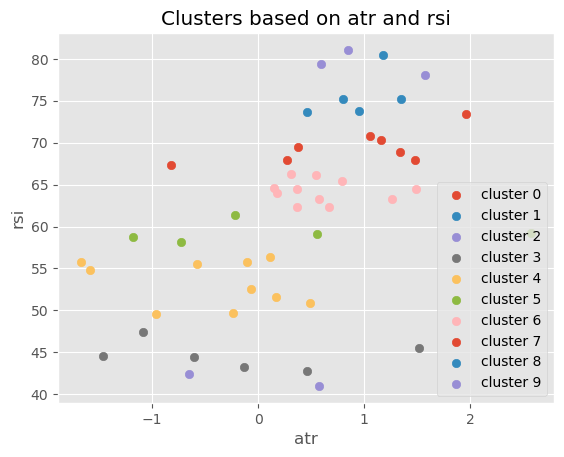

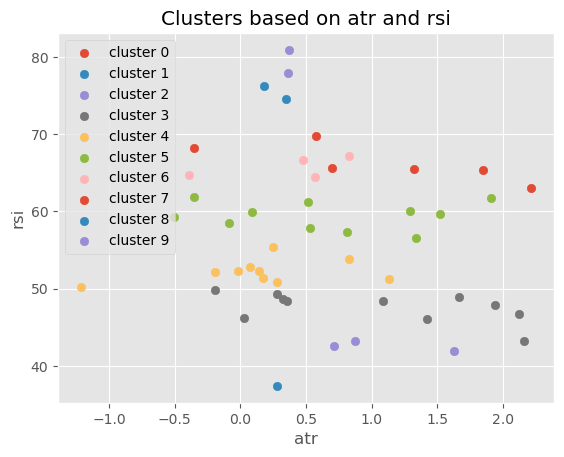

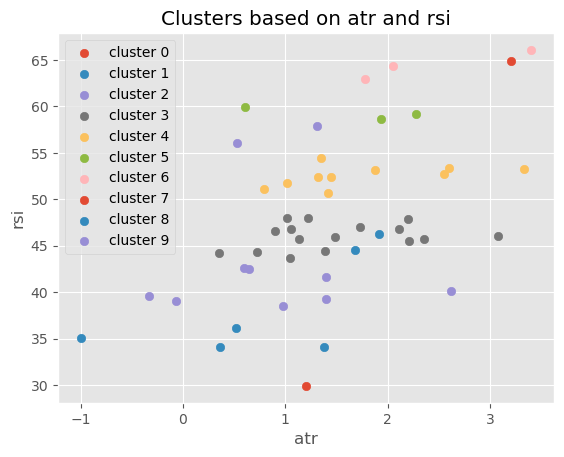

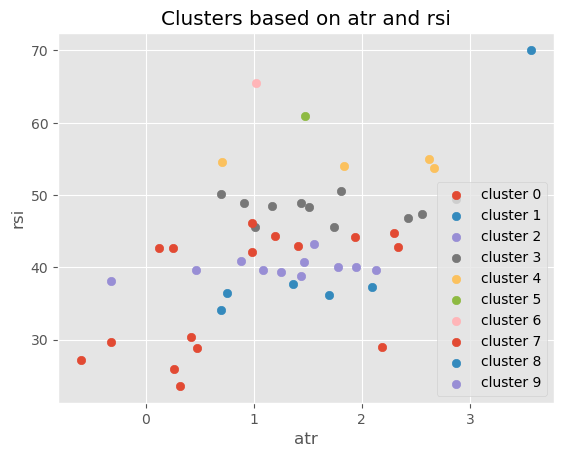

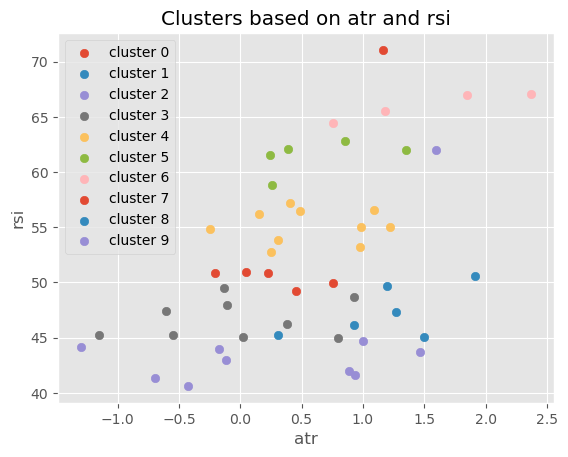

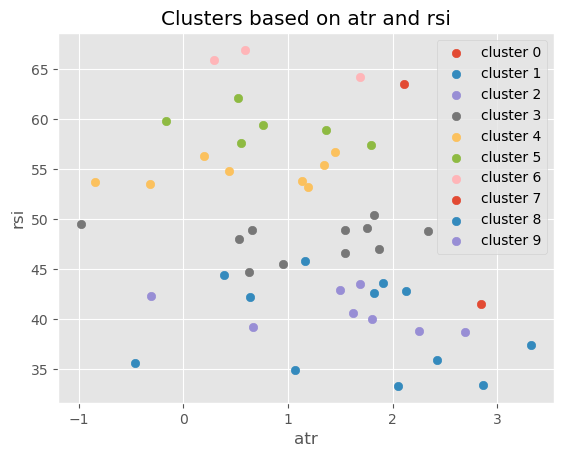

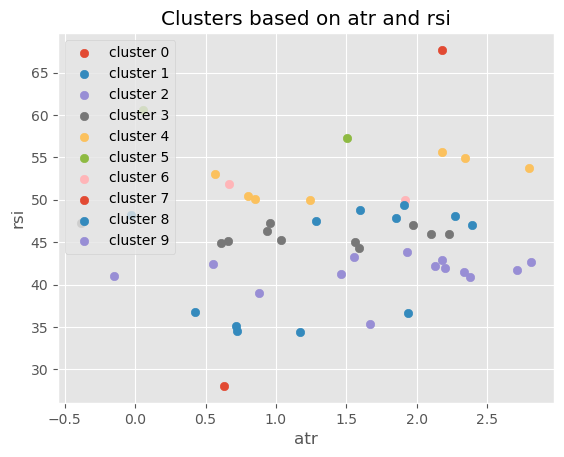

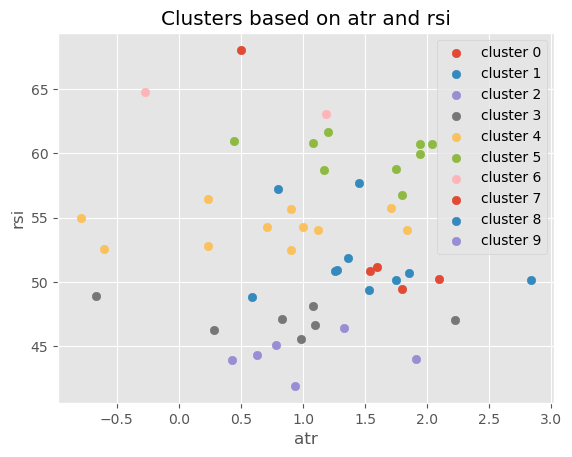

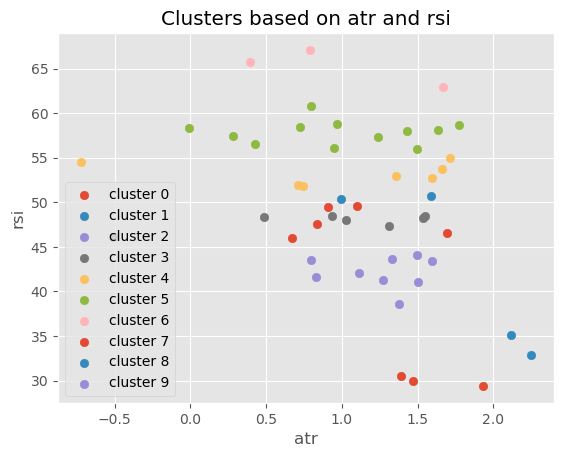

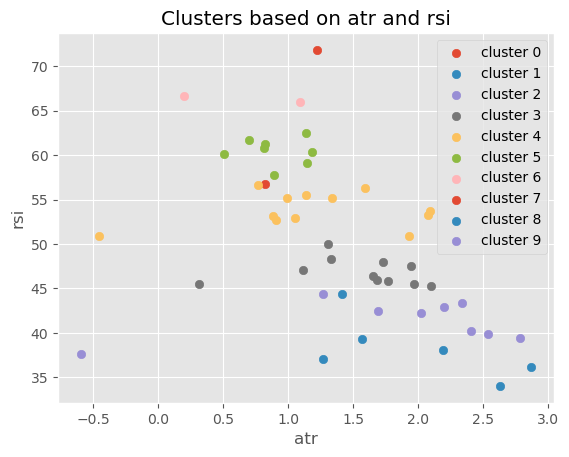

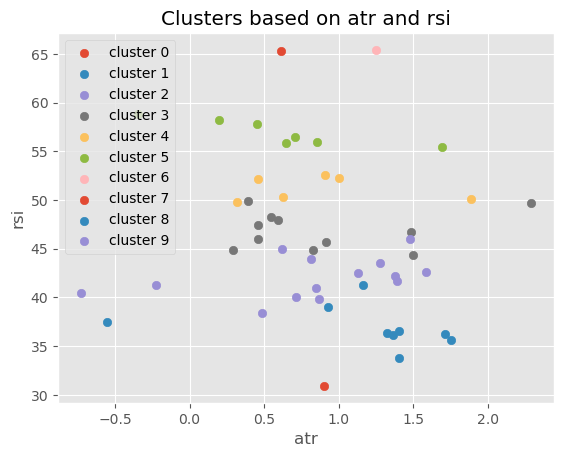

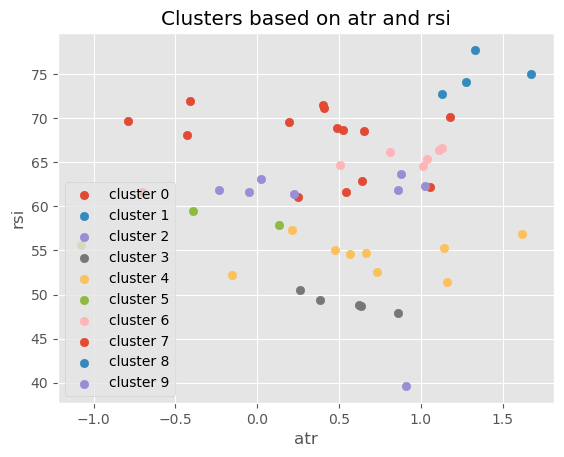

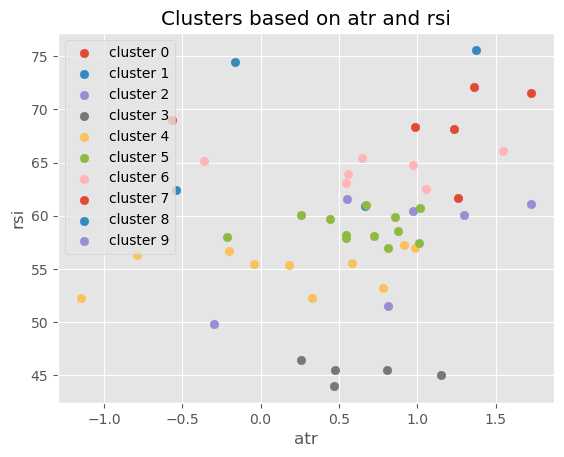

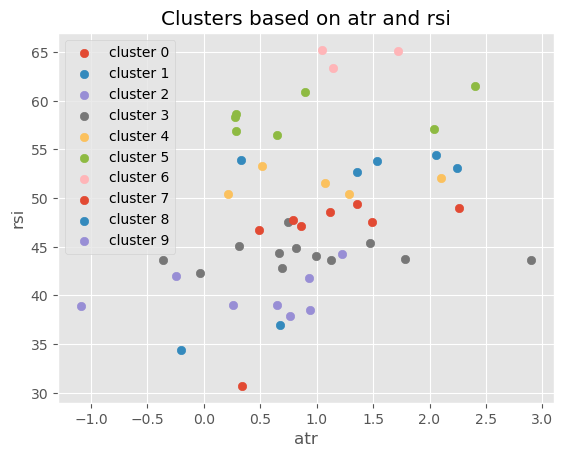

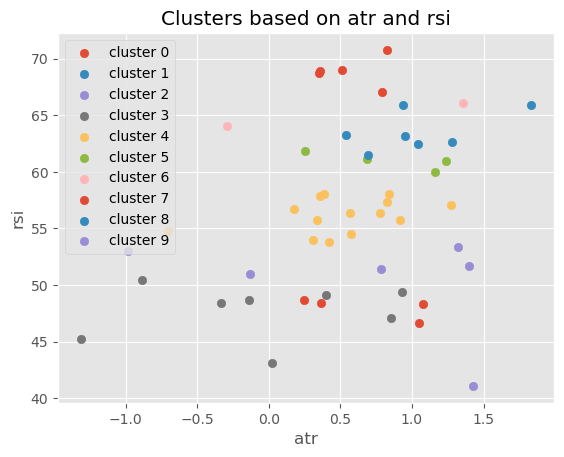

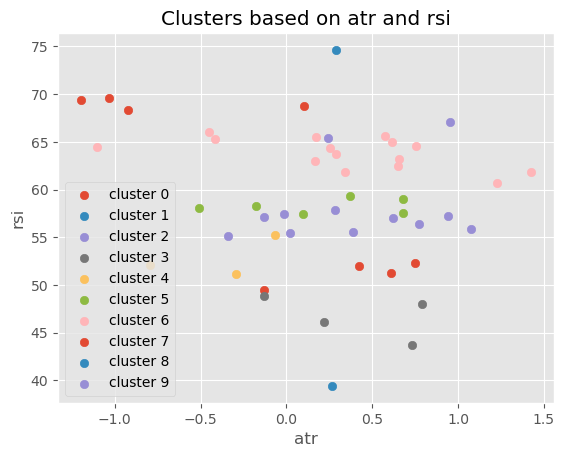

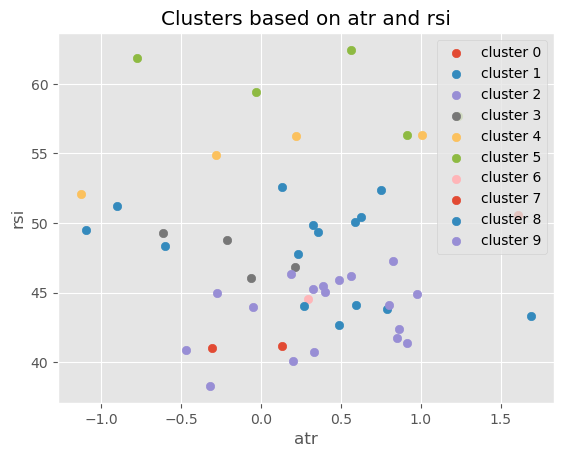

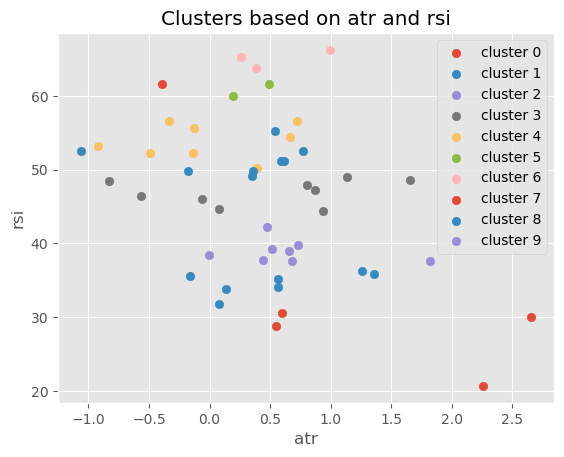

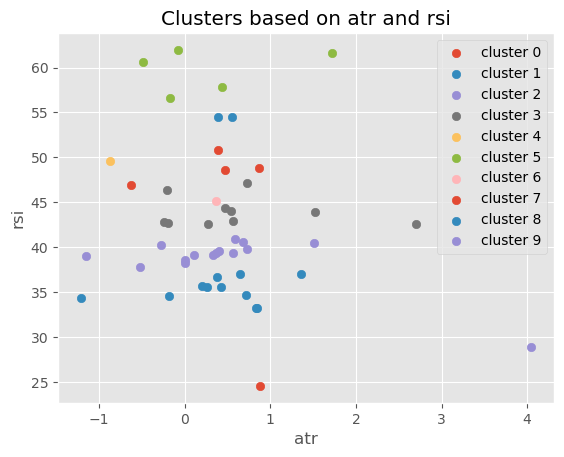

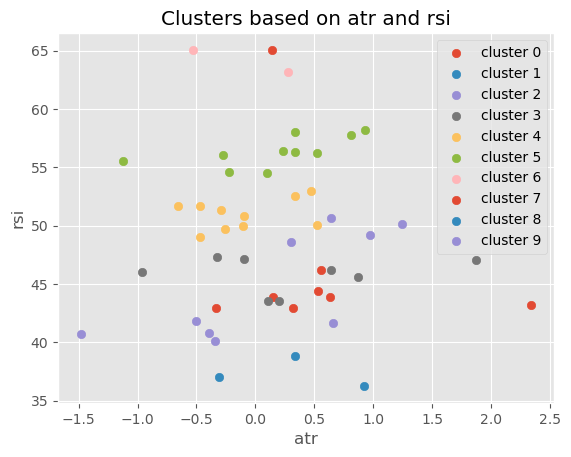

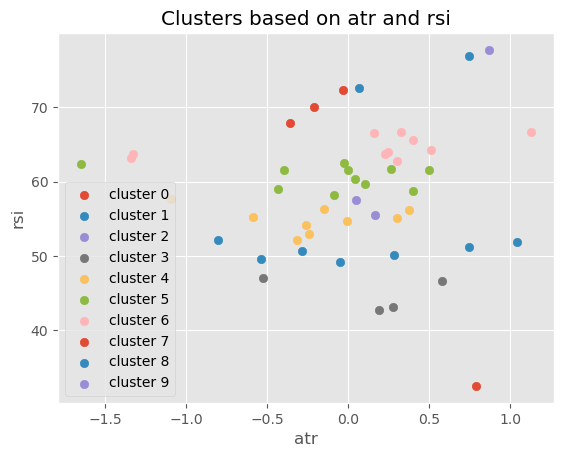

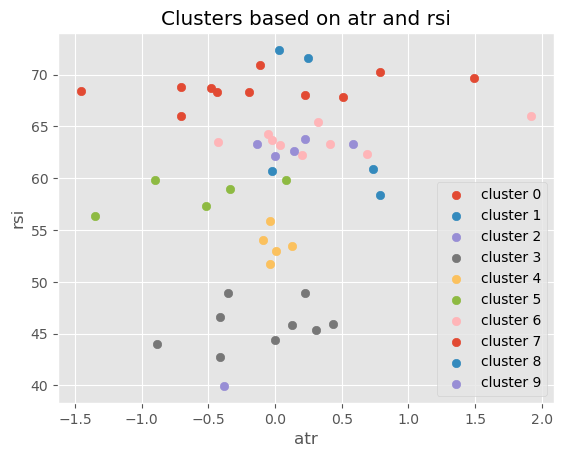

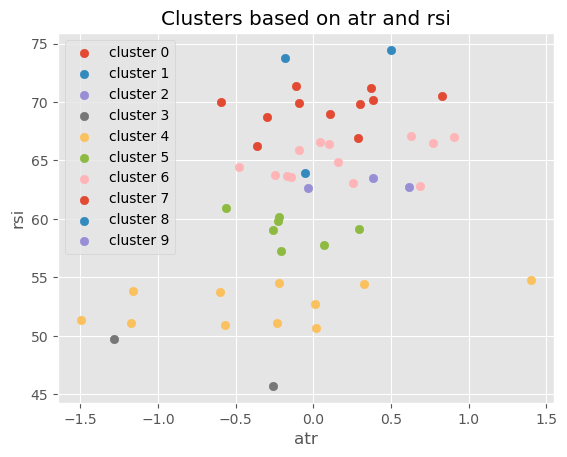

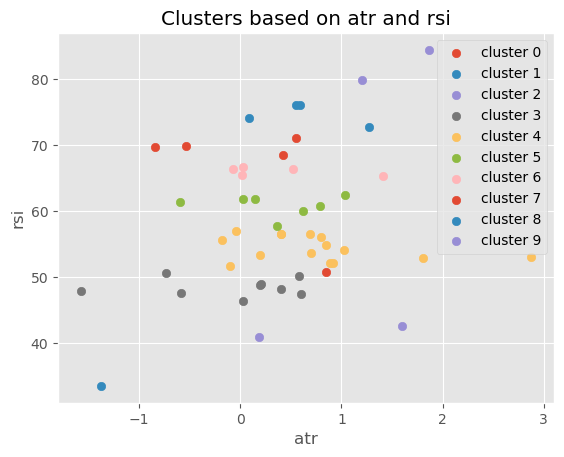

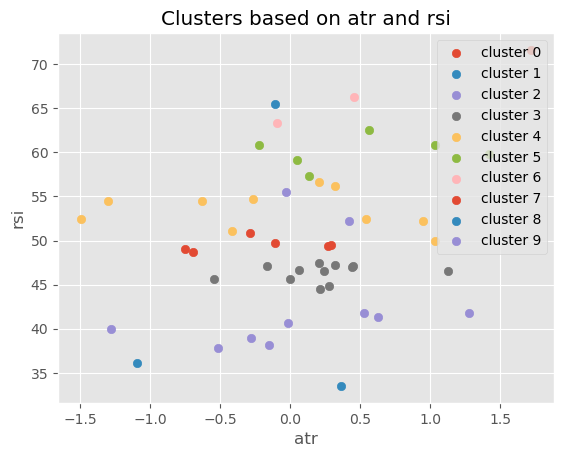

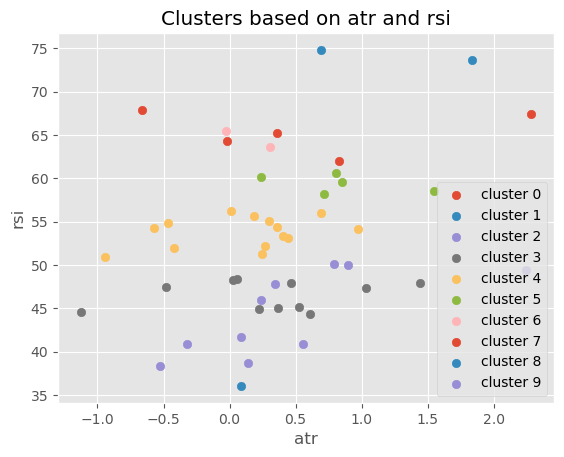

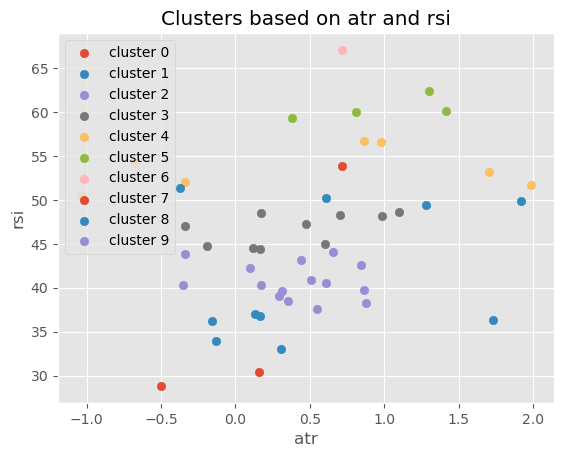

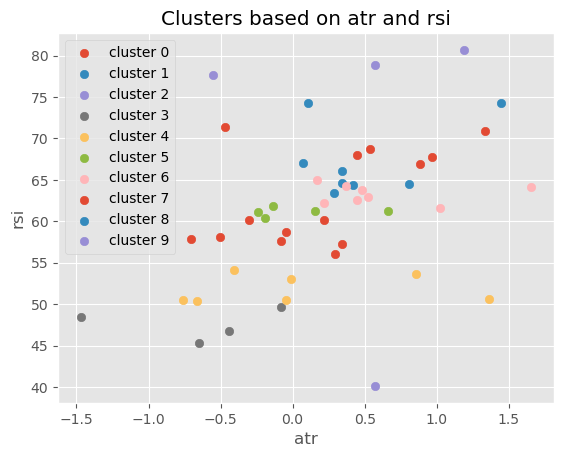

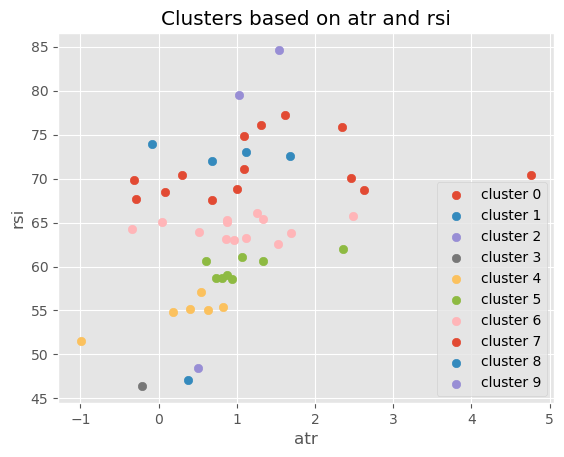

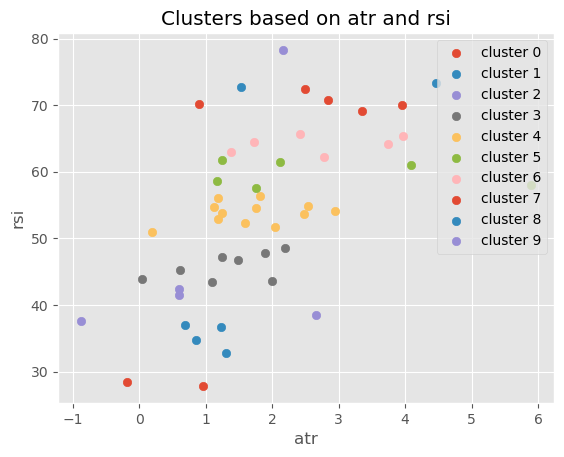

In [19]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

In [20]:
target_rsi_values = [30,35,40,45,55,60,65,70,75,80]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 1] = target_rsi_values

initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 35.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 40.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 60.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 65.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 75.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 80.,  0.,  0.,  0.,  0.,

# 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization
* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.

In [21]:
filtered_df = data[data['cluster']==3].copy()  # eveything lies here so use cluster value carefull

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {} # declare dictionary

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates


{'2017-04-01': ['AXISBANK.NS', 'COALINDIA.NS', 'TATAMOTORS.NS'],
 '2017-05-01': ['ADANIENT.NS', 'HCLTECH.NS', 'TATAMOTORS.NS', 'WIPRO.NS'],
 '2017-06-01': ['APOLLOHOSP.NS',
  'BAJAJ-AUTO.NS',
  'BAJAJFINSV.NS',
  'ULTRACEMCO.NS'],
 '2017-07-01': ['BAJAJFINSV.NS',
  'HINDALCO.NS',
  'INFY.NS',
  'NTPC.NS',
  'SUNPHARMA.NS',
  'TATACONSUM.NS',
  'WIPRO.NS'],
 '2017-08-01': ['APOLLOHOSP.NS',
  'DIVISLAB.NS',
  'HEROMOTOCO.NS',
  'TATAMOTORS.NS',
  'ULTRACEMCO.NS'],
 '2017-09-01': ['AXISBANK.NS',
  'HCLTECH.NS',
  'KOTAKBANK.NS',
  'LT.NS',
  'LTIM.NS',
  'UPL.NS'],
 '2017-10-01': ['ADANIPORTS.NS',
  'BAJAJFINSV.NS',
  'HEROMOTOCO.NS',
  'HINDUNILVR.NS',
  'INFY.NS',
  'LT.NS',
  'RELIANCE.NS',
  'TCS.NS',
  'TITAN.NS'],
 '2017-11-01': ['ASIANPAINT.NS',
  'BAJFINANCE.NS',
  'HDFCBANK.NS',
  'KOTAKBANK.NS',
  'UPL.NS'],
 '2017-12-01': ['ADANIPORTS.NS',
  'BPCL.NS',
  'CIPLA.NS',
  'COALINDIA.NS',
  'GRASIM.NS',
  'HCLTECH.NS',
  'JSWSTEEL.NS',
  'POWERGRID.NS',
  'TATASTEEL.NS',
  'WIPRO.NS

# Define portfolio optimization function
* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [22]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

In [23]:
stocks = data.index.get_level_values('ticker').unique().tolist()
new_df= yf.download(tickers= stocks,
                    start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12)
                    ,end=data.index.get_level_values('date').unique()[-1])
new_df

[*********************100%%**********************]  50 of 50 completed


Adj Close                                            \
            ADANIENT.NS ADANIPORTS.NS APOLLOHOSP.NS ASIANPAINT.NS   
Date                                                                
2016-03-31    39.402477    237.887421   1297.792603    822.555786   
2016-04-01    40.630470    233.277573   1316.976685    824.071411   
2016-04-04    43.006363    232.941437   1322.248779    839.368896   
2016-04-05    39.749519    217.287140   1315.317017    823.929199   
2016-04-06    40.310123    215.462418   1317.171997    817.725037   
...                 ...           ...           ...           ...   
2024-01-23  2896.550049   1137.099976   6153.750000   3054.699951   
2024-01-24  2903.449951   1120.599976   6213.350098   2999.449951   
2024-01-25  2893.600098   1146.300049   6168.850098   2949.199951   
2024-01-29  3064.649902   1196.650024   6329.750000   2976.050049   
2024-01-30  3091.100098   1187.349976   6309.799805   2954.100098   

                                                                   \
            AXISBANK.NS BAJAJ-AUTO.NS BAJAJFINSV.NS BAJFINANCE.NS   
Date                                                                
2016-03-31   434.108948   1893.576538    170.553818    676.747253   
2016-04-01   439.728943   1904.516235    174.107224    672.187622   
2016-04-04   434.695374   1926.868164    174.560715    671.425293   
2016-04-05   422.820068   1884.840332    174.311539    666.914795   
2016-04-06   415.049774   1885.115601    175.971146    679.034180   
...                 ...           ...           ...           ...   
2024-01-23  1089.250000   7095.899902   1582.500000   7070.700195   
2024-01-24  1059.150024   7212.850098   1620.849976   7055.299805   
2024-01-25  1042.250000   7597.500000   1630.150024   7085.500000   
2024-01-29  1061.250000   7548.799805   1636.949951   7191.649902   
2024-01-30  1054.099976   7566.399902   1590.550049   6817.200195   

                                      ...       Volume                \
           BHARTIARTL.NS     BPCL.NS  ... SUNPHARMA.NS TATACONSUM.NS   
Date                                  ...                              
2016-03-31    303.655396  192.524033  ...      5230705       1627181   
2016-04-01    290.368347  188.894089  ...      1654746       1532533   
2016-04-04    301.664581  188.840851  ...      1239310        831737   
2016-04-05    286.083557  189.564697  ...      2570634       1663091   
2016-04-06    289.546021  189.511475  ...      1809628       1327276   
...                  ...         ...  ...          ...           ...   
2024-01-23   1158.000000  463.049988  ...      4129729        933643   
2024-01-24   1189.949951  477.149994  ...      1719845       1040096   
2024-01-25   1160.550049  474.399994  ...      1870910       1125321   
2024-01-29   1162.150024  492.649994  ...      3413149       1588430   
2024-01-30   1158.650024  504.200012  ...      1935332        798009   

                                                                  \
           TATAMOTORS.NS TATASTEEL.NS   TCS.NS TECHM.NS TITAN.NS   
Date                                                               
2016-03-31      10738707    140121880  4363964  4630177   895578   
2016-04-01       5683771     58463365  3041400  2394963   517494   
2016-04-04       6011729     54242901  1752352  1708093   796436   
2016-04-05       6058241     60071721  1491794  1430387   829255   
2016-04-06       7323269    153148901  1763150  2671558  1075449   
...                  ...          ...      ...      ...      ...   
2024-01-23       9436209     35373970  2618854  2683661  1053510   
2024-01-24       7217542     39340119  2657709  2008135   636988   
2024-01-25      10109720     61358839  2205154  8424862   646135   
2024-01-29      12823686     29745400  1646747  2495791   699215   
2024-01-30      19734613     35704185  1411621  2293154   852445   

                                             
           ULTRACEMCO.NS   UPL.NS  WIPRO.NS  
Date                      

In [24]:
data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12)

Timestamp('2016-03-31 00:00:00')

* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

In [25]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df
    

Max Sharpe Optimization failed for 2017-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-07-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-08-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-11-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-08-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-09-01, Continuing with Equal-Weights

Strategy Return
date                       
2017-04-03         0.012496
2017-04-05         0.001637
2017-04-06        -0.004170
2017-04-07        -0.009354
2017-04-10         0.012297
...                     ...
2024-01-23        -0.049509
2024-01-24        -0.007707
2024-01-25        -0.004566
2024-01-29        -0.000778
2024-01-30        -0.006155

[1687 rows x 1 columns]

<Axes: xlabel='date'>

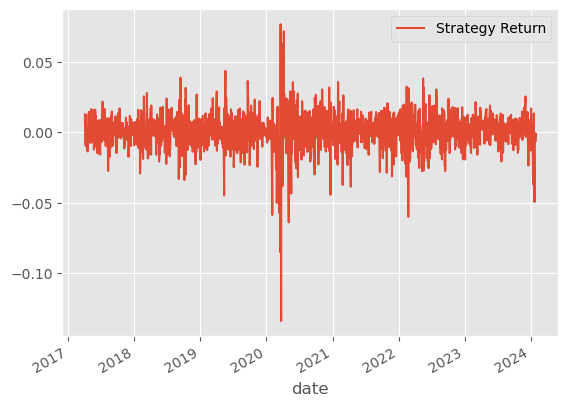

In [26]:
portfolio_df.plot()

In [27]:
pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T

AXISBANK.NS  EICHERMOT.NS  INDUSINDBK.NS  JSWSTEEL.NS  M&M.NS  MARUTI.NS  \
0        0.125         0.125          0.125        0.125   0.125      0.125   

   NESTLEIND.NS  SBILIFE.NS  
0         0.125       0.125

In [28]:
nifty = yf.download(tickers='^NSEI',
                  start='2015-01-01',
                  end=dt.date.today())

nifty_ret = np.log(nifty[['Adj Close']]).diff().dropna().rename({'Adj Close':'nifty Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(nifty_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


Strategy Return  nifty Buy&Hold
2017-04-03         0.012496        0.006963
2017-04-05         0.001637        0.002951
2017-04-06        -0.004170       -0.000345
2017-04-07        -0.009354       -0.006896
2017-04-10         0.012297       -0.001833
...                     ...             ...
2024-01-23        -0.049509       -0.017900
2024-01-24        -0.007707        0.010079
2024-01-25        -0.004566       -0.004735
2024-01-29        -0.000778        0.017870
2024-01-30        -0.006155       -0.009963

[1683 rows x 2 columns]

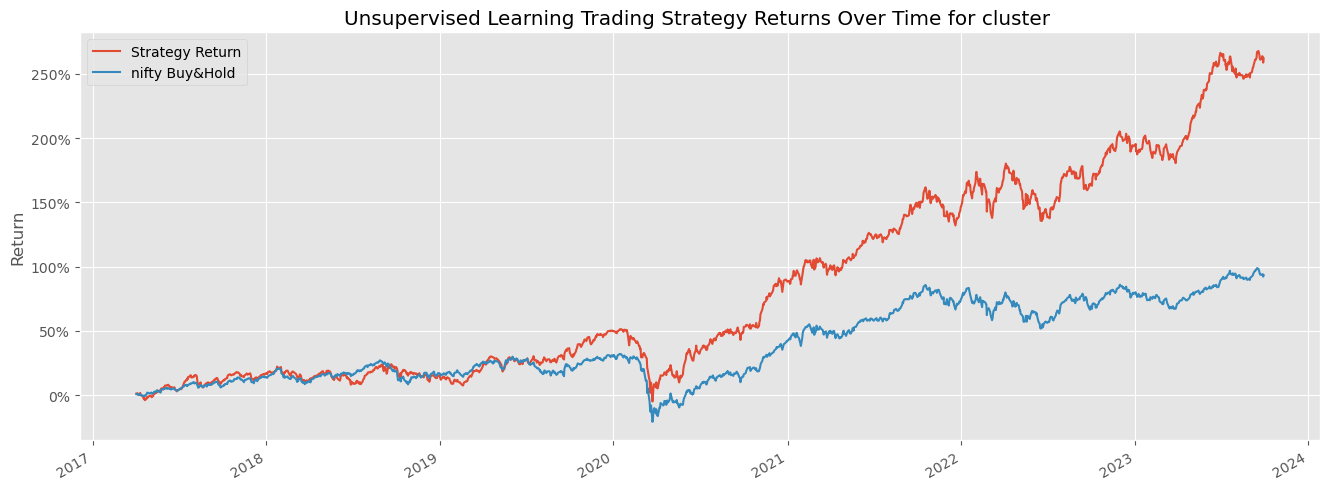

In [29]:
import matplotlib.ticker as mtick
unique_clusters = data['cluster'].unique()

for cluster_number in unique_clusters:
    filtered_df = data[data['cluster'] == cluster_number].copy()

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time for cluster ')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()




In [30]:
import numpy as np

# Assuming 'portfolio_df' has the 'Strategy Return' and 'nifty Buy&Hold' columns
strategy_returns = portfolio_df['Strategy Return']
nifty_returns = portfolio_df['nifty Buy&Hold']

# Calculate Sharpe ratio for the strategy
strategy_sharpe_ratio = np.sqrt(252) * strategy_returns.mean() / strategy_returns.std()

# Calculate Sharpe ratio for NIFTY 50
nifty_sharpe_ratio = np.sqrt(252) * nifty_returns.mean() / nifty_returns.std()

# Print the Sharpe Ratios
print(f"Strategy Sharpe Ratio: {strategy_sharpe_ratio:.4f}")
print(f"NIFTY 50 Sharpe Ratio: {nifty_sharpe_ratio:.4f}")


Strategy Sharpe Ratio: 1.0696
NIFTY 50 Sharpe Ratio: 0.7282


In [31]:
# Given data
stock_data = {
    'BAJFINANCE': [7259.35, 7314.55, 0.760399],
    'ICICIBANK': [946.70, 1015.70, 7.28848],
    'INDUSINDBK': [1461.15, 1497.50, 2.48777],
    'ITC': [449.90, 453.10, 0.711269],
    'KOTAKBANK': [1750.50, 1824.35, 4.21879],
    'SBIN': [571.75, 612.40, 7.10975],
    'ASIANPAINT': [3173.40, 3243.65, 2.21371],
    'CIPLA': [1205.70, 1216.50, 0.895745],
    'TCS': [3511.65, 3593.55, 2.33224],
    'UPL': [575.15, 599.35, 4.2076]
}

# Calculating total increase
total_increase = sum(stock[2] for stock in stock_data.values())

# Displaying the total increase
print(f'Total Increase: {total_increase:.2f}%')

Total Increase: 32.23%


In [32]:
apar= yf.download('APARINDS.NS',start="2010-01-01",end="2024-02-01")

[*********************100%%**********************]  1 of 1 completed
